# TODO:


- Why did we remove Curricular units columns?
- Check mappings - is the classification of mother’s and father’s occupation and qualification ok?
- Which features should be protected: It may depend on the purpose: If the purpose is to help students, it may not be important to remove features related to e.g. gender and social background
- Write documentation for functions
- delete unused things e.g. geometric implementation, if we don't want to use it
- Make a function for deciding lambda (how much to decorrelate the data?)
- Decide hyper parameters?
- Shap-values
- Look at correlations // I have tried to make a plot function
- other things?


In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import  pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import scipy
import os
from sklearn.decomposition import PCA

from ucimlrepo import fetch_ucirepo

import warnings
warnings.filterwarnings('ignore')

# Constants

In [185]:
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

In [186]:
# Mapping of occupation codes to occupation names
occupation_names = {
    0: 'Student',
    1: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions',
    4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers',
    10: 'Armed Forces Professions',
    90: 'Other Situation',
    99: '(blank)',
    101: 'Armed Forces Officers', # Only Father
    102: 'Armed Forces Sergeants', # Only Father
    103: 'Other Armed Forces personnel', # Only Father
    112: 'Directors of administrative and commercial services', # Only Father
    114: 'Hotel, catering, trade and other services directors', # Only Father
    121: 'Specialists in the physical sciences, mathematics, engineering and related techniques', # Only Father
    122: 'Health professionals',
    123: 'Teachers',
    124: 'Specialists in finance, accounting, administrative organization, public and commercial relations', # Only Father
    125: 'Specialists in information and communication technologies (ICT)', # Only Mother
    131: 'Intermediate level science and engineering technicians and professions',
    132: 'Technicians and professionals, of intermediate level of health',
    134: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    135: 'Information and communication technology technicians', # Only Father
    141: 'Office workers, secretaries in general and data processing operators',
    143: 'Data, accounting, statistical, financial services and registry-related operators',
    144: 'Other administrative support staff',
    151: 'Personal service workers',
    152: 'Sellers',
    153: 'Personal care workers and the like',
    154: 'Protection and security services personnel', # Only Father
    161: 'Market-oriented farmers and skilled agricultural and animal production workers', # Only Father
    163: 'Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence', # Only Father
    171: 'Skilled construction workers and the like, except electricians',
    172: 'Skilled workers in metallurgy, metalworking and similar', # Only Father
    174: 'Skilled workers in electricity and electronics', # Only Father
    173: 'Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like', # Only Mother
    175: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    181: 'Fixed plant and machine operators', # Only Father
    182: 'Assembly workers', # Only Father
    183: 'Vehicle drivers and mobile equipment operators', # Only Father
    191: 'Cleaning workers', # Only Mother
    192: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    193: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    194: 'Meal preparation assistants',
    195: 'Street vendors (except food) and street service providers' # Only Father
}

## 1: Unskilled Workers, 2: Skilled Workers, 3: Intermediate Level Technicians and Professions, 4: Administrative staff, Managers, and Specialists, 5: Managers, and Specialists, Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers
occupation_worker_levels = {
    0: 0,  # Student
    1: 5,  # Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers
    2: 3,  # Specialists in Intellectual and Scientific Activities
    3: 3,  # Intermediate Level Technicians and Professions
    4: 4,  # Administrative staff
    5: 2,  # Personal Services, Security and Safety Workers and Sellers
    6: 2,  # Farmers and Skilled Workers in Agriculture, Fisheries and Forestry
    7: 2,  # Skilled Workers in Industry, Construction and Craftsmen
    8: 2,  # Installation and Machine Operators and Assembly Workers
    9: 1,  # Unskilled Workers
    10: 2, # Armed Forces Professions
    90: 0, # Other Situation
    99: 0, # (blank)
    101: 2, # Armed Forces Officers
    102: 2, # Armed Forces Sergeants
    103: 2, # Other Armed Forces personnel
    112: 4, # Directors of administrative and commercial services
    114: 4, # Hotel, catering, trade and other services directors
    121: 3, # Specialists in the physical sciences, mathematics, engineering and related techniques
    122: 3, # Health professionals
    123: 3, # Teachers
    124: 4, # Specialists in finance, accounting, administrative organization, public and commercial relations
    125: 4, # Specialists in information and communication technologies (ICT)
    131: 3, # Intermediate level science and engineering technicians and professions
    132: 3, # Technicians and professionals, of intermediate level of health
    134: 3, # Intermediate level technicians from legal, social, sports, cultural and similar services
    135: 3, # Information and communication technology technicians
    141: 3, # Office workers, secretaries in general and data processing operators
    143: 3, # Data, accounting, statistical, financial services and registry-related operators
    144: 4, # Other administrative support staff
    151: 2, # Personal service workers
    152: 2, # Sellers
    153: 2, # Personal care workers and the like
    154: 2, # Protection and security services personnel
    161: 2, # Market-oriented farmers and skilled agricultural and animal production workers
    163: 2, # Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence
    171: 2, # Skilled construction workers and the like, except electricians
    172: 2, # Skilled workers in metallurgy, metalworking and similar
    174: 2, # Skilled workers in electricity and electronics
    173: 2, # Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like
    175: 2, # Workers in food processing, woodworking, clothing and other industries and crafts
    181: 2, # Fixed plant and machine operators
    182: 2, # Assembly workers
    183: 2, # Vehicle drivers and mobile equipment operators
    191: 1, # Cleaning workers
    192: 1, # Unskilled workers in agriculture, animal production, fisheries and forestry
    193: 1, # Unskilled workers in extractive industry, construction, manufacturing and transport
    194: 1, # Meal preparation assistants
    195: 2  # Street vendors (except food) and street service providers
}


# Mapping of qualification codes to qualification names
qualification_names = {
    1: 'Secondary Education - 12th Year of Schooling or Eq.',
    2: "Higher Education - Bachelor's Degree",
    3: 'Higher Education - Degree',
    4: "Higher Education - Master's",
    5: "Higher Education - Doctorate",
    6: 'Frequency of Higher Education',
    9: '12th Year of Schooling - Not Completed',
    10: '11th Year of Schooling - Not Completed',
    11: '7th Year (Old)',
    12: 'Other - 11th Year of Schooling',
    13: '2nd year complementary high school course', # Only Father
    14: '10th Year of Schooling',
    18: 'General commerce course',
    19: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    20: 'Complementary High School Course', # Only Father
    22: 'Technical-professional course',
    25: 'Complementary High School Course - not concluded',
    26: '7th year of schooling',
    27: '2nd cycle of the general high school course',
    29: '9th Year of Schooling - Not Completed',
    30: '8th year of schooling',
    31: 'General Course of Administration and Commerce', # Only Father
    33: 'Supplementary Accounting and Administration', # Only Father
    34: 'Unknown',
    35: "Can't read or write",
    36: 'Can read without having a 4th year of schooling',
    37: 'Basic education 1st cycle (4th/5th year) or equiv.',
    38: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    39: 'Technological specialization course',
    40: 'Higher education - degree (1st cycle)',
    41: 'Specialized higher studies course',
    42: 'Professional higher technical course',
    43: 'Higher Education - Master (2nd cycle)',
    44: 'Higher Education - Doctorate (3rd cycle)',
}

# Group -1: Others
# Group 0: No Education??
# Group 1: Basic Education,
# Group 2: Secondary Education
# Group 3: Higher Education (1st Cycle??)
# Group 4: Higher Education (Bachelor's Degree)
# Group 5: Higher Education (2nd Cycle??)
# Group 6: Higher Education (3rd Cycle??)


qualification_groups = {
    1: 1,   # Secondary Education - 12th Year of Schooling or Eq.
    2: 4,   # Higher Education - Bachelor's Degree
    3: 4,   # Higher Education - Degree
    4: 5,   # Higher Education - Master's
    5: 6,   # Higher Education - Doctorate
    6: -1,   # Frequency of Higher Education
    9: 1,   # 12th Year of Schooling - Not Completed
    10: 1,  # 11th Year of Schooling - Not Completed
    11: 1,  # 7th Year (Old)
    12: 1,  # Other - 11th Year of Schooling
    13: 2,  # 2nd year complementary high school course
    14: 1,  # 10th Year of Schooling
    18: 4,  # General commerce course
    19: 1,  # Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.
    20: 1,  # Complementary High School Course
    22: 3,  # Technical-professional course
    25: 1,  # Complementary High School Course - not concluded
    26: 1,  # 7th year of schooling
    27: 1,  # 2nd cycle of the general high school course
    29: 1,  # 9th Year of Schooling - Not Completed
    30: 1,  # 8th year of schooling
    31: 4,  # General Course of Administration and Commerce
    33: 4,  # Supplementary Accounting and Administration
    34: -1,  # Unknown
    35: 0,  # Can't read or write
    36: 0,  # Can read without having a 4th year of schooling
    37: 1,  # Basic education 1st cycle (4th/5th year) or equiv.
    38: 1,  # Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.
    39: 3,  # Technological specialization course
    40: 4,  # Higher education - degree (1st cycle)
    41: 4,  # Specialized higher studies course
    42: 4,  # Professional higher technical course
    43: 5,  # Higher Education - Master (2nd cycle)
    44: 6   # Higher Education - Doctorate (3rd cycle)
}


# Mother's and Father's qualification
education_levels = {
    34: 0,  # Unknown
    35: 1,  # Can't read or write
    36: 2,  # Can read without having a 4th year of schooling
    37: 3,  # Basic education 1st cycle (4th/5th year) or equiv.
    38: 4,  # Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.
    19: 5,  # Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.
    14: 6,  # 10th Year of Schooling
    10: 7,  # 11th Year of Schooling - Not Completed
    9: 8,   # 12th Year of Schooling - Not Completed
    1: 9,   # Secondary Education - 12th Year of Schooling or Eq.
    26: 10, # 7th year of schooling
    30: 11, # 8th year of schooling
    25: 12, # Complementary High School Course - not concluded
    20: 13, # Complementary High School Course
    27: 14, # 2nd cycle of the general high school course
    13: 15, # 2nd year complementary high school course
    22: 16, # Technical-professional course
    18: 17, # General commerce course
    31: 18, # General Course of Administration and Commerce
    33: 19, # Supplementary Accounting and Administration
    39: 20, # Technological specialization course
    40: 21, # Higher education - degree (1st cycle)
    2: 22,  # Higher Education - Bachelor's Degree
    3: 23,  # Higher Education - Degree
    4: 24,  # Higher Education - Master's
    43: 25, # Higher Education - Master (2nd cycle)
    5: 26,  # Higher Education - Doctorate
    44: 27, # Higher Education - Doctorate (3rd cycle)
    6: 28,  # Frequency of Higher Education
    41: 29, # Specialized higher studies course
    42: 30  # Professional higher technical course
}

course_names = {
    33: 'Biofuel Production Technologies',
    171: 'Animation and Multimedia Design',
    8014: 'Social Service (evening attendance)',
    9003: 'Agronomy',
    9070: 'Communication Design',
    9085: 'Veterinary Nursing',
    9119: 'Informatics Engineering',
    9130: 'Equinculture',
    9147: 'Management',
    9238: 'Social Service',
    9254: 'Tourism',
    9500: 'Nursing',
    9556: 'Oral Hygiene',
    9670: 'Advertising and Marketing Management',
    9773: 'Journalism and Communication',
    9853: 'Basic Education',
    9991: 'Management (evening attendance)'
}

# Functions
- Data Processing Functions
- Model Evaluation Functions
- Visualization Functions

## Data Processing Functions
- load_data()
- get_test_and_training_data(test_size=0.2)

In [187]:
def load_data(protected_cols=[]):
    predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)
    df = predict_students_dropout_and_academic_success.data.features

    df_init = df.copy() # Incl. Curricular attributes

    ## Remove Features related to Curricular units
    df = df[['Marital Status', 'Application mode', 'Application order', 'Course',
           'Daytime/evening attendance', 'Previous qualification',
           'Previous qualification (grade)',
           'Admission grade', 'Displaced', 'Educational special needs', 'Debtor',
           'Tuition fees up to date',
           'International', 'Unemployment rate',
           'Inflation rate', 'GDP',
           "Mother's qualification", "Father's qualification",
           "Mother's occupation", "Father's occupation",
           'Scholarship holder', 'Age at enrollment', 'Nacionality', 'Gender']]


    # Make a binary column for dropout
    data_y = predict_students_dropout_and_academic_success.data.targets
    data_y = data_y.Target.apply(lambda x: 1 if x == 'Dropout' else 0)
    df['Dropout'] = data_y

    # # Make a binary column for mother's and father's class based on their occupations
    df["Mother's occupation"] = df["Mother's occupation"].map(occupation_worker_levels)
    df["Father's occupation"] = df["Father's occupation"].map(occupation_worker_levels)
    df["Mother's qualification"] = df["Mother's qualification"].map(qualification_groups)
    df["Father's qualification"] = df["Father's qualification"].map(qualification_groups)

    #protected_cols = ['Gender', "Mother's occupation", "Father's occupation"]

    labels = df[['Dropout']]
    groups = df[protected_cols]

    features_full = df.copy()
    df.drop('Dropout', axis=1, inplace=True)
    features = df.copy()
    features_protected = pd.concat([df[x] for x in protected_cols], axis=1)

    for x in protected_cols:
      df.drop(x, axis=1, inplace=True)

    features_np = df.copy()

    return features, features_full, labels, groups, features_np, features_protected, protected_cols


def get_test_and_training_data(features, labels, group, protected_cols=[], test_size=0.2): # take  group,  as arugment
    X, y = features, labels

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(X, y, group, test_size=test_size, random_state=seed)

    # Subset for protected and non-protected features
    X_train_p = X_train[protected_cols]
    X_train_np = X_train.drop(columns=protected_cols)
    X_test_p = X_test[protected_cols]
    X_test_np = X_test.drop(columns=protected_cols)

    return X_train, X_test, y_train, y_test, X_train_p, X_train_np, X_test_p, X_test_np, group_train, group_test


In [188]:
def standard_scale(X_train, X_test): ## We need to scale within the cross val step to avoid data leakage
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train))
    X_test = pd.DataFrame(scaler.transform(X_test))
    return X_train, X_test

### A Geometric Solution to Fair Representations

In [189]:
def debias_features(X, protected_idx, l=0):
    '''Based on exercises. Debias using de-correllation'''

    #FunctionTransfomer makes it an array and I want it to be a dataFrame
    X = pd.DataFrame(X) #This makes no difference

    X_p = X[protected_idx]
    X_np = X.drop(columns=protected_idx)

    # Find the basis from the protected attributes
    orthbasis = scipy.linalg.orth(X_p)

    # Debias nonprotected features by projecting them onto the basis
    X_np_debiased = X_np - orthbasis @ orthbasis.T @ X_np

    # Return debiased nonprotected features, tempered by lambda: r′_j(λ) = r_j + λ⋅ (x_j− r_j)
    return pd.DataFrame(X_np_debiased + l * (X_np - X_np_debiased))


In [190]:
# Define a class for Fair PCA
class FairPCA:
    def __init__(self, Xs, p_idxs, n_components):
        self.fit(Xs, p_idxs, n_components)

    def fit(self, Xs, p_idxs, n_components):
        # Extract protected features
        Xs_p = Xs.iloc[:, p_idxs]

        # Compute projection matrix (U)
        # Set z
        Z = Xs_p

        # Compute orthonormal null-space spanned by Z.T @ Xs
        Z = Z - Z.mean(0) #center
        R = scipy.linalg.null_space(Z.T @ Xs)

        # Compute orthonormal eigenvectors (L)
        eig_vals, L = scipy.linalg.eig(R.T @ Xs.T @ Xs @ R)

        # U = R * Eigenvectors
        self.U = R @ L[:, :n_components]

    def project(self, Xs):
        # Project data into fair space using projection matrix U
        return Xs @ self.U


class NormalPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components, random_state=seed)

    def fit(self, X):
        self.pca.fit(X)

    def project(self, X):
        return self.pca.transform(X)


def debias_features_adjust_fairness_level(X_fair, X_pca, l=0):
    # r′j(λ) = rj + λ⋅ (xj− rj)
    return X_fair + l * (X_pca - X_fair)


## Model Evaluation Functions
- standard_scale
- cross_validator
- fairness metrics

In [191]:
def get_debiased_data(X_train, X_test, protected_cols, lambd=0):
  nonprotected_cols = [col for col in X_train.columns if col not in protected_cols]
  protected_idx = [X_train.columns.get_loc(col) for col in protected_cols]

  X_train, X_test = standard_scale(X_train, X_test)

  X_train_debiased = debias_features(X_train, protected_idx, l=lambd) # using decorrelation
  X_train_debiased.columns = nonprotected_cols # Assume the order is the same

  X_test = X_test.drop(columns=protected_idx)
  X_test.columns = nonprotected_cols

  return X_train_debiased, X_test

In [192]:
def get_pca_data(X_train, X_test, protected_cols, lambd=0):
  nonprotected_cols = [col for col in X_train.columns if col not in protected_cols]
  protected_idx = [X_train.columns.get_loc(col) for col in protected_cols]

  n_components = len(X_train.columns) - len(protected_idx)

  fair = FairPCA(X_train, protected_idx, n_components)
  norm = NormalPCA(n_components)
  norm.fit(X_train)

  X_train_debiased = fair.project(X_train)
  X_test_debiased = fair.project(X_test)
  X_train_pca = norm.project(X_train)
  X_test_pca = norm.project(X_test)

  X_train_final = debias_features_adjust_fairness_level(X_train_debiased, X_train_pca, l=lambd)
  X_test_final = debias_features_adjust_fairness_level(X_test_debiased, X_test_pca, l=lambd)



  return X_train_final, X_test_final

In [193]:
def cross_validator(model, X, y, protected_cols=[], n=5, debias=False, lambd=0):
    kfold = StratifiedKFold(n, shuffle=True, random_state=seed)

    y_hat = np.zeros(len(y))

    for train_idx, test_idx in kfold.split(X, y): ## Split based on both X and y
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        if debias:
          X_train, X_test = get_pca_data(X_train, X_test, protected_cols=protected_cols, lambd=lambd)
          #X_train, X_test = get_debiased_data(X_train, X_test, protected_cols, lambd=lambd) #### This is if you want to use the geometric version

        else:
          X_train, X_test = standard_scale(X_train, X_test)


        model = model.fit(X_train, y_train)
        y_hat[test_idx] = model.predict(X_test)

    return y_hat

### Metrics



In [194]:
# Generates a dataframe for computing fairness metrics
def make_df(y_test, y_pred, group_test):
    df = pd.DataFrame(y_pred, columns=['S'])
    df['G'] = group_test
    df['A'] = y_test
    return df

# Calculates statistical parity for multiple groups
def stat_parity(df, groups):
    return [sum(df[df['G'] == g].S) / df[df['G'] == g].shape[0] for g in groups]

# Calculates equal odds for a specified target outcome and multiple groups
def equal_odds(df, target=1, groups=None):
    return [sum(df[(df['G'] == g) & (df['A'] == target)].S) / df[(df['G'] == g) & (df['A'] == target)].shape[0] for g in groups]

# Calculates equal outcomes for a specified sensitive attribute and multiple groups
def equal_outcomes(df, s=1, groups=None):
    return [sum(df[(df['G'] == g) & (df['S'] == s)].A) / df[(df['G'] == g) & (df['S'] == s)].shape[0] for g in groups]

# Calculates accuracy for multiple groups
def accuracy(df, groups=None):
    return [balanced_accuracy_score(df[(df['G'] == g) & df['A'].notna()].A, df[(df['G'] == g) & df['A'].notna()].S) for g in groups]

# Names of the fairness metrics
metric_names = ["stat_parity", "odds_t0", "odds_t1", "outcome_s0", "outcome_s1", "accuracy"]

# Computes fairness metric scores
def metric_scores(y_test, y_pred, group_test, df=None):
    if df is None:
        df = make_df(y_test, y_pred, group_test)

    groups = df['G'].unique()
    return [stat_parity(df, groups),
            equal_odds(df, target=0, groups=groups),
            equal_odds(df, target=1, groups=groups),
            equal_outcomes(df, s=0, groups=groups),
            equal_outcomes(df, s=1, groups=groups),
            accuracy(df, groups=groups)]


def metric_df(scores, group_names, names=metric_names):
    df_fair_metrics = pd.DataFrame({"score":[], "metric" : [], "group":[]})
    for i in range(len(names)):
        #g1,g2 = scores[i]
        new_metrics = {"score": scores[i], "metric" : [names[i] for _ in range(len(group_names))], "group":group_names}
        df_fair_metrics = pd.concat([df_fair_metrics, pd.DataFrame(new_metrics)], ignore_index=True)

    return df_fair_metrics

## Visualization Functions

### Plot Correlation

In [195]:
def corr_mat(X, method='pearson'):
    '''The code is adapted from solution to data debias exercises
    Takes a dataframe and computes the correlations, and their
    statistical significance between all features,
    returning 2 arrays: correlations, and p_values'''
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Compute correlation matrix
    n_features = X.shape[1]

    corr_ = np.zeros((n_features, n_features))
    p_ = np.zeros((n_features, n_features))

    if method == 'pearson':
        corr_func = pearsonr
    elif method == 'spearman':
        corr_func = spearmanr
    else:
        raise ValueError("Unsupported correlation method. Supported methods are 'pearson' and 'spearman'.")

    for i in range(n_features):
        for j in range(n_features):
            corr_[i,j], p_[i,j] = corr_func(X[:,i], X[:,j])
            corr_ = np.nan_to_num(corr_, 0)
            # Handle NaN values in correlation coefficient by setting p-value to 1
            if np.isnan(corr_[i,j]):
                p_[i,j] = 1

    return corr_, p_

def plot_corr(df, method='pearson', feature_cols=[], show_specific_features=False, num_corr=None):
    corr_name = ""
    if method == 'pearson':
        corr_name = "Pearson's "
    elif method == 'spearman':
        corr_name = "Spearman's "
    else:
        raise ValueError("Unsupported correlation method. Supported methods are 'pearson' and 'spearman'.")

    corr, p = corr_mat(df, method)
    feature_idx = [df.columns.get_loc(col) for col in feature_cols]

    alpha = 0.05 # Significance level
    corrected_alpha = alpha / (df.shape[1]**2/2) #bonferronni correction


    if show_specific_features and len(feature_cols)==1 and num_corr:
      corr_spec_feature = corr[feature_idx[0]]

      features_sorted_spec_feature = [ y for x,y in sorted(zip(corr_spec_feature, features), key = lambda x: abs(x[0]), reverse = True)]
      corr_sorted_spec_feature = [ x for x,y in sorted(zip(corr_spec_feature, features), key = lambda x: abs(x[0]), reverse = True)]

      features_num_corr_spec_feature = features_sorted_spec_feature[1:(num_corr+1)]
      corr_num_corr_spec_feature = corr_sorted_spec_feature[1:(num_corr+1)]

      # Plot 10 highest correlations with specific feature
      x_pos = np.arange(len(features_num_corr_spec_feature))

      plt.figure(figsize=(8,6))

      colors = []
      for i in corr_num_corr_spec_feature:
          if i > 0:
              colors.append("#ffcea5")
          else:
              colors.append("#c9ffc7")


      for i in range(len(x_pos)):
          plt.bar(x_pos[i], corr_num_corr_spec_feature[i], color = colors[i], align='center')

      plt.xticks(x_pos, features_num_corr_spec_feature, rotation = 45, ha = 'right')
      plt.xlabel("Feature", fontsize = 12)
      plt.ylabel('Correlation', fontsize = 12)
      plt.title(f'All bonferroni p-values are significant (lower than 5%)', fontsize = 12)
      plt.suptitle(f'{feature_cols[0]}: {num_corr} highest {corr_name}correlations', fontsize = 14)

      plt.tight_layout()
      plt.show()


    else:
      if show_specific_features:
        plt.figure(figsize=(len(feature_cols),9))

        sns.heatmap(corr[:, feature_idx], cmap="coolwarm", xticklabels=df.columns[feature_idx], yticklabels=df.columns,
              mask = p[:, feature_idx]  > corrected_alpha, vmin=-1, vmax=1, square=True)
      else:
        plt.figure(figsize=(15,15))
        sns.heatmap(corr, cmap="coolwarm",
                    xticklabels=df.columns, yticklabels=df.columns,
                    square=True, vmin=-1, vmax=1, mask= p > corrected_alpha)



      plt.title(f"{corr_name}Correlation Coeff between all features (filtered by p > {alpha})")
      plt.show()

### Plot Feature

In [196]:
def plot_feature(feature_name, feature_mapping, features_full, column_feature='Dropout', colors=['#c9ffc7', '#ffcea5'], show_ratio=True, labels=['No', 'Yes']):
  # Data
  tmp_full_features = features_full.copy()
  tmp_full_features[feature_name] = tmp_full_features[feature_name].map(feature_mapping)
  counts = tmp_full_features.groupby([feature_name, column_feature]).size().unstack(fill_value=0)

  # Calculate column_feature ratio
  if show_ratio:
    counts[f'{column_feature} Ratio'] = counts[1] / (counts[0] + counts[1])

  # Plotting
  fig, ax1 = plt.subplots(figsize=(12, 8))

  # Plotting column_feature counts
  bar_width = 0.35
  positions = np.arange(len(counts))

  ax1.bar(positions - bar_width/2, counts[1], width=bar_width, color=colors[1], label=labels[1])
  ax1.bar(positions + bar_width/2, counts[0], width=bar_width, color=colors[0], label=labels[0])
  ax1.set_ylabel('Number of Students', color='black')
  ax1.tick_params(axis='y', labelcolor='black')
  ax1.set_xticks(positions)
  ax1.set_xticklabels(counts.index, rotation=90, ha='center')
  ax1.legend(title=column_feature, loc='upper left')

  # Creating a second y-axis for column_feature ratio
  if show_ratio:
    ax2 = ax1.twinx()
    ax2.plot(positions, counts[f'{column_feature} Ratio'], color='red', marker='o', linestyle='-')
    ax2.set_ylabel(f'{column_feature} Ratio', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f"Distribution of {feature_name} and {column_feature} Ratio")
  else:
    plt.title(f"Distribution of {feature_name} by {column_feature}")

  plt.tight_layout()
  plt.show()


### Model Evaluation Plots

In [197]:
def plot_scores_and_group(df, title=None):
  # Plotting
  fig, ax = plt.subplots(figsize=(10, 6))
  #groups = df['group'].unique()
  metrics = df['metric'].unique()
  bar_width = 0.35
  index = range(len(metrics))

  color_palette = sns.color_palette("pastel", n_colors=len(df['group'].unique()))


  for i, group in enumerate(df['group'].unique()):
      values = df[df['group'] == group]['score']
      ax.bar([x + i * bar_width for x in index], values, bar_width, label=group, color=color_palette[i])

  ax.set_xlabel('Metric')
  ax.set_ylabel('Score')
  if title:
    ax.set_title(title)
  else:
    ax.set_title('Scores by Metric and Group')
  ax.set_xticks([x + bar_width for x in index])
  ax.set_xticklabels(metrics)
  ax.legend()

  plt.tight_layout()
  plt.show()

def plot_scores_and_group_compare(df1, df2, titles=None, color_palette=None, bar_width=0.35):
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)  # Create subplots side by side ####################

    # Iterate over DataFrames
    for i, (ax, df) in enumerate(zip(axes, [df1, df2])):
        metrics = df['metric'].unique()
        index = range(len(metrics))

        if not color_palette:
          color_palette = sns.color_palette("pastel", n_colors=len(df['group'].unique()))


        for j, group in enumerate(df['group'].unique()):
            values = df[df['group'] == group]['score']
            ax.bar([x + j * bar_width for x in index], values, bar_width, label=group, color=color_palette[j])

        ax.set_xlabel('Metric')
        if titles:
            ax.set_title(titles[i])
        else:
            ax.set_title('Scores by Metric and Group')

        ax.set_xticks([x + bar_width for x in index])
        ax.set_xticklabels(metrics)

    # Set common y-label and legend
    axes[0].set_ylabel('Score')
    axes[0].legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

### Tune Hyper Params

In [198]:
def tune_hyper_params(features, model, fixed_model_params, param_to_tune, param_values):

  def get_model(value):
    fixed_model_params[param_to_tune] = value
    return model(**fixed_model_params)

  debiased_data_np, data_np = get_debiased_data(features, features, protected_cols)

  descriptions = ['original data', 'nonprotected features', 'debiased data']
  datasets = [features, data_np, debiased_data_np]
  for data_X, desc in zip(datasets, descriptions):
    accuracies = []
    for v in param_values:
      model_with_params = get_model(v)
      preds = cross_validator(model_with_params, data_X, labels, protected_cols=protected_cols)
      acc = balanced_accuracy_score(preds, labels)
      accuracies.append(acc)

    plt.plot(param_values, accuracies)
    plt.title(f'Accuracy at different values of {param_to_tune} for {desc}')
    plt.xlabel(f'{param_to_tune}')
    plt.ylabel('Accuracy')
    plt.show()

## Explainability

In [199]:
def feature_weights(features, model, top_n=10):

  debiased_data_np, data_np = get_debiased_data(features, features, protected_cols)

  descriptions = ['original data', 'nonprotected features', 'debiased data']
  datasets = [features, data_np, debiased_data_np]

  weights_dfs = []

  for dataset in datasets:
    model.fit(dataset,labels)
    odds = pd.DataFrame(model.coef_[0], dataset.columns, columns=['coef'])
    odds ['odds'] = np.exp(odds.coef)
    odds['abs_odds'] = abs(odds.coef)
    odds = odds.sort_values(by='abs_odds', ascending=False).drop('abs_odds', axis=1)
    odds = odds.round(decimals=3)

    weights_dfs.append(odds.head(top_n))

  return weights_dfs



# Load Data

In [200]:
features, features_full, labels, groups, features_np, features_p, protected_cols = load_data(protected_cols=['Gender', "Mother's occupation", "Father's occupation"])

# Exploratory Data Analysis (EDA)

In [201]:
features_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital Status,4424.0,1.178571,0.605747,1.00,1.0,1.00,1.00,6.00
Application mode,4424.0,18.669078,17.484682,1.00,1.0,17.00,39.00,57.00
Application order,4424.0,1.727848,1.313793,0.00,1.0,1.00,2.00,9.00
Course,4424.0,8856.642631,2063.566416,33.00,9085.0,9238.00,9556.00,9991.00
Daytime/evening attendance,4424.0,0.890823,0.311897,0.00,1.0,1.00,1.00,1.00
Previous qualification,4424.0,4.577758,10.216592,1.00,1.0,1.00,1.00,43.00
Previous qualification (grade),4424.0,132.613314,13.188332,95.00,125.0,133.10,140.00,190.00
Admission grade,4424.0,126.978119,14.482001,95.00,117.9,126.10,134.80,190.00
Displaced,4424.0,0.548373,0.497711,0.00,0.0,1.00,1.00,1.00
Educational special needs,4424.0,0.011528,0.106760,0.00,0.0,0.00,0.00,1.00


## Imbalance in Dropout

Number of rows with dropout is 1421, corresponding to 32.12 % of the data
Number of rows with dropout is 3003, corresponding to 67.88 % of the data
Imbalance Ratio (IR) is 2.11



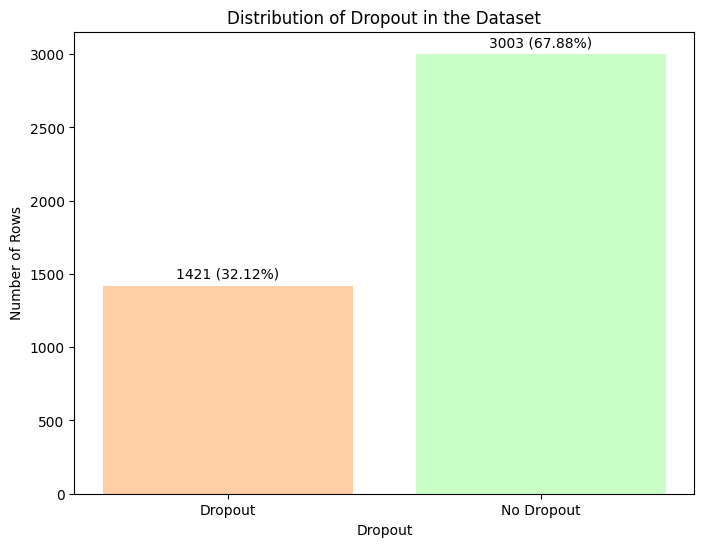

In [202]:
# Data
rows_dropout = len(features_full[features_full.Dropout == 1].index)
rows_not_dropout = len(features_full[features_full.Dropout == 0].index)
total_rows = len(features_full)

# Calculate percentages
dropout_percentage = 100 * rows_dropout / total_rows
not_dropout_percentage = 100 * rows_not_dropout / total_rows


print(f"Number of rows with dropout is {rows_dropout}, corresponding to {np.round(100 * rows_dropout/len(features_full),2)} % of the data")
print(f"Number of rows with dropout is {rows_not_dropout}, corresponding to {np.round(100 * rows_not_dropout/len(features_full),2)} % of the data")

print(f"Imbalance Ratio (IR) is {np.round(rows_not_dropout/rows_dropout,2)}\n")

# Plotting
labs = ['Dropout', 'No Dropout']
values = [rows_dropout, rows_not_dropout]

plt.figure(figsize=(8, 6))
plt.bar(labs, values, color=['#ffcea5', '#c9ffc7'])
plt.xlabel('Dropout')
plt.ylabel('Number of Rows')
plt.title('Distribution of Dropout in the Dataset')

# Add percentages on top of bars
for i in range(len(labs)):
    plt.text(i, values[i] + 50, f'{values[i]} ({np.round(100 * values[i]/total_rows, 2)}%)', ha='center')

plt.show()

## Representations bias: higher education institutions with a majority of females are overrepresented

In Portugal, 49% of 25-34 year-old women had a tertiary qualification in 2020 compared to 35% of their male peers.


https://www.oecd-ilibrary.org/sites/db0e552c-en/index.html?itemId=/content/component/db0e552c-en

The higher imbalance ratio in our dataset compared to OECD data could be attributed to the composition of higher education institutions. For instance, programs like Nursing and Veterinary Nursing, which typically enroll a higher number of females, may contribute to this imbalance. Conversely, fields such as Law Enforcement Studies and more technical courses, which tend to attract more males, might not be represented in our dataset, further skewing the gender distribution.

OECD Imbalance Ratio (IR) is 1.4
Number of rows with male that ends graduating is 855, corresponding to 19.33 % of the data
Number of rows with female that ends graduating is 2148, corresponding to 48.55 % of the data
Dataset Imbalance Ratio (IR) is 2.51



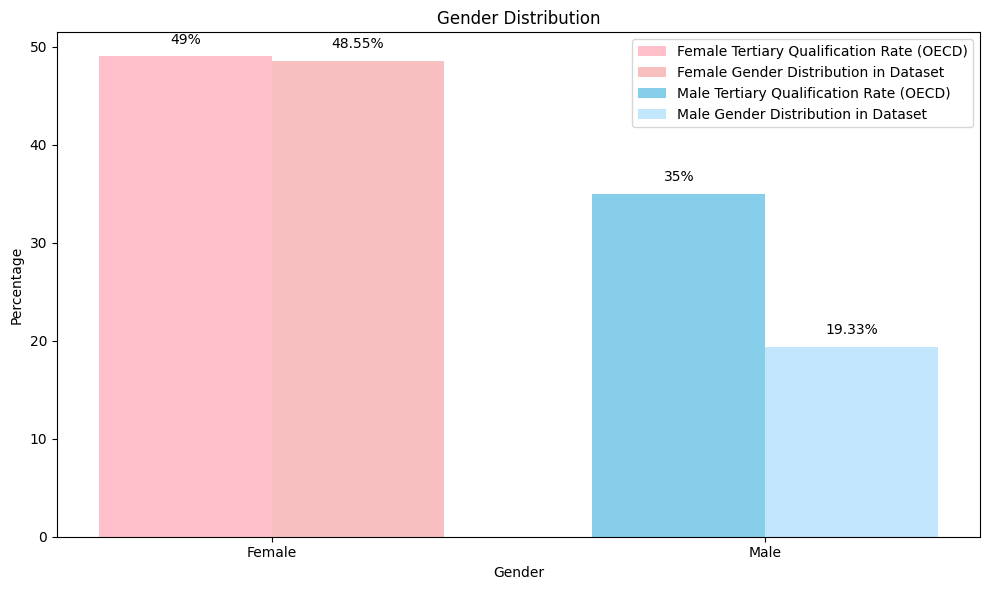

In [203]:
# OECD Data
female_tertiary = 49  # percentage of 25-34 year-old women with tertiary qualification
male_tertiary = 35    # percentage of 25-34 year-old men with tertiary qualification

print(f"OECD Imbalance Ratio (IR) is {np.round(female_tertiary/male_tertiary,2)}")

# Data: Calculate percentages
rows_male = len(features_full[(features_full.Gender == 1) & (features_full.Dropout == 0)].index)
rows_female = len(features_full[(features_full.Gender == 0) & (features_full.Dropout == 0)].index)
total_rows = len(features_full)

male_percentage = 100 * rows_male / total_rows
female_percentage = 100 * rows_female / total_rows
print(f"Number of rows with male that ends graduating is {rows_male}, corresponding to {np.round(100 * rows_male/len(features_full),2)} % of the data")
print(f"Number of rows with female that ends graduating is {rows_female}, corresponding to {np.round(100 * rows_female/len(features_full),2)} % of the data")
print(f"Dataset Imbalance Ratio (IR) is {np.round(rows_female/rows_male,2)}\n")

labels_data = ['Male', 'Female']
values_data = [rows_male, rows_female]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(2)

# Bar plot for female tertiary qualification rates
bar1 = ax.bar(index[0] - bar_width/2, female_tertiary, bar_width, color='pink', label='Female Tertiary Qualification Rate (OECD)')
bar2 = ax.bar(index[0] + bar_width/2, female_percentage, bar_width, color='lightcoral', alpha=0.5, label='Female Gender Distribution in Dataset')
bar3 = ax.bar(index[1] - bar_width/2, male_tertiary, bar_width, color='skyblue', label='Male Tertiary Qualification Rate (OECD)')
bar4 = ax.bar(index[1] + bar_width/2, male_percentage, bar_width, color='lightskyblue', alpha=0.5, label='Male Gender Distribution in Dataset')

ax.set_xlabel('Gender')
ax.set_ylabel('Percentage')
ax.set_title('Gender Distribution')
ax.set_xticks(index)
ax.set_xticklabels(['Female', 'Male'])
ax.legend()

# Add text annotations
ax.text(index[0] - bar_width/2, female_tertiary + 1, f'{female_tertiary}%', ha='center', va='bottom')
ax.text(index[1] - bar_width/2, male_tertiary + 1, f'{male_tertiary}%', ha='center', va='bottom')
ax.text(index[0] + bar_width/2, female_percentage + 1, f'{np.round(female_percentage,2)}%', ha='center', va='bottom')
ax.text(index[1] + bar_width/2, male_percentage + 1, f'{np.round(male_percentage,2)}%', ha='center', va='bottom')


plt.tight_layout()
plt.show()


OECD Imbalance Ratio (IR) is 1.4
Number of rows with male is 1556, corresponding to 35.17 % of the data
Number of rows with female is 2868, corresponding to 64.83 % of the data
Dataset Imbalance Ratio (IR) is 1.84



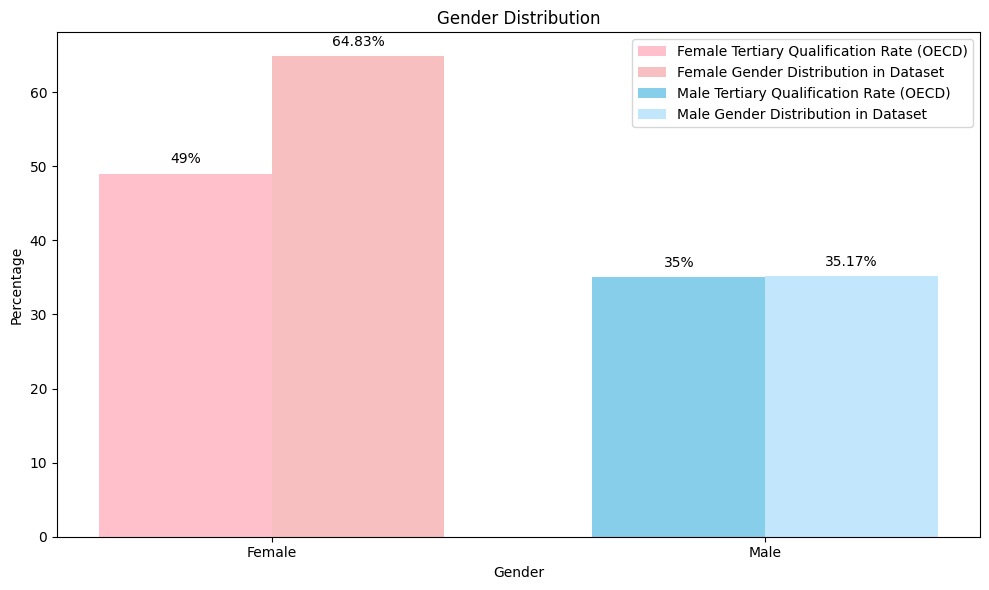

In [204]:
# OECD Data
female_tertiary = 49  # percentage of 25-34 year-old women with tertiary qualification
male_tertiary = 35    # percentage of 25-34 year-old men with tertiary qualification

print(f"OECD Imbalance Ratio (IR) is {np.round(female_tertiary/male_tertiary,2)}")

# Data: Calculate percentages
rows_male = len(features_full[features_full.Gender == 1].index)
rows_female = len(features_full[features_full.Gender == 0].index)
total_rows = len(features_full)

male_percentage = 100 * rows_male / total_rows
female_percentage = 100 * rows_female / total_rows
print(f"Number of rows with male is {rows_male}, corresponding to {np.round(100 * rows_male/len(features_full),2)} % of the data")
print(f"Number of rows with female is {rows_female}, corresponding to {np.round(100 * rows_female/len(features_full),2)} % of the data")
print(f"Dataset Imbalance Ratio (IR) is {np.round(rows_female/rows_male,2)}\n")

labels_data = ['Male', 'Female']
values_data = [rows_male, rows_female]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(2)

# Bar plot for female tertiary qualification rates
bar1 = ax.bar(index[0] - bar_width/2, female_tertiary, bar_width, color='pink', label='Female Tertiary Qualification Rate (OECD)')
bar2 = ax.bar(index[0] + bar_width/2, female_percentage, bar_width, color='lightcoral', alpha=0.5, label='Female Gender Distribution in Dataset')
bar3 = ax.bar(index[1] - bar_width/2, male_tertiary, bar_width, color='skyblue', label='Male Tertiary Qualification Rate (OECD)')
bar4 = ax.bar(index[1] + bar_width/2, male_percentage, bar_width, color='lightskyblue', alpha=0.5, label='Male Gender Distribution in Dataset')

ax.set_xlabel('Gender')
ax.set_ylabel('Percentage')
ax.set_title('Gender Distribution')
ax.set_xticks(index)
ax.set_xticklabels(['Female', 'Male'])
ax.legend()

# Add text annotations
ax.text(index[0] - bar_width/2, female_tertiary + 1, f'{female_tertiary}%', ha='center', va='bottom')
ax.text(index[1] - bar_width/2, male_tertiary + 1, f'{male_tertiary}%', ha='center', va='bottom')
ax.text(index[0] + bar_width/2, female_percentage + 1, f'{np.round(female_percentage,2)}%', ha='center', va='bottom')
ax.text(index[1] + bar_width/2, male_percentage + 1, f'{np.round(male_percentage,2)}%', ha='center', va='bottom')


plt.tight_layout()
plt.show()


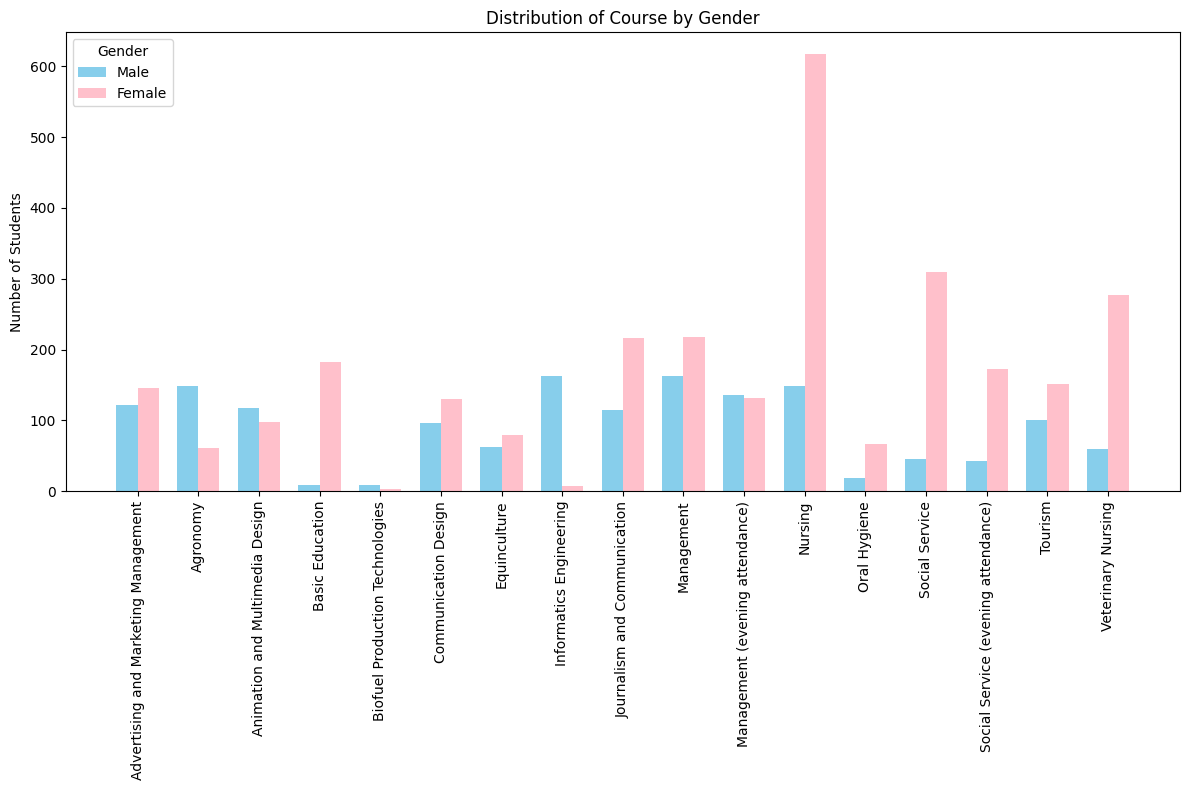

In [205]:
feature_name = "Course"
plot_feature(feature_name, course_names, features_full, column_feature='Gender', colors=['pink', 'skyblue'], labels=['Female', 'Male'], show_ratio=False)

## Social Inheritance? and data representation bias?

- Parent's ualification is hard to conclude on as the data is kind of imbalanced
- Parents' occupation seems to have more influence, and is easier to conclude on as the groups seems to be a bit more balanced.

It seems to show that the drop out ratio is the highest if the student have parents in worker class 0.

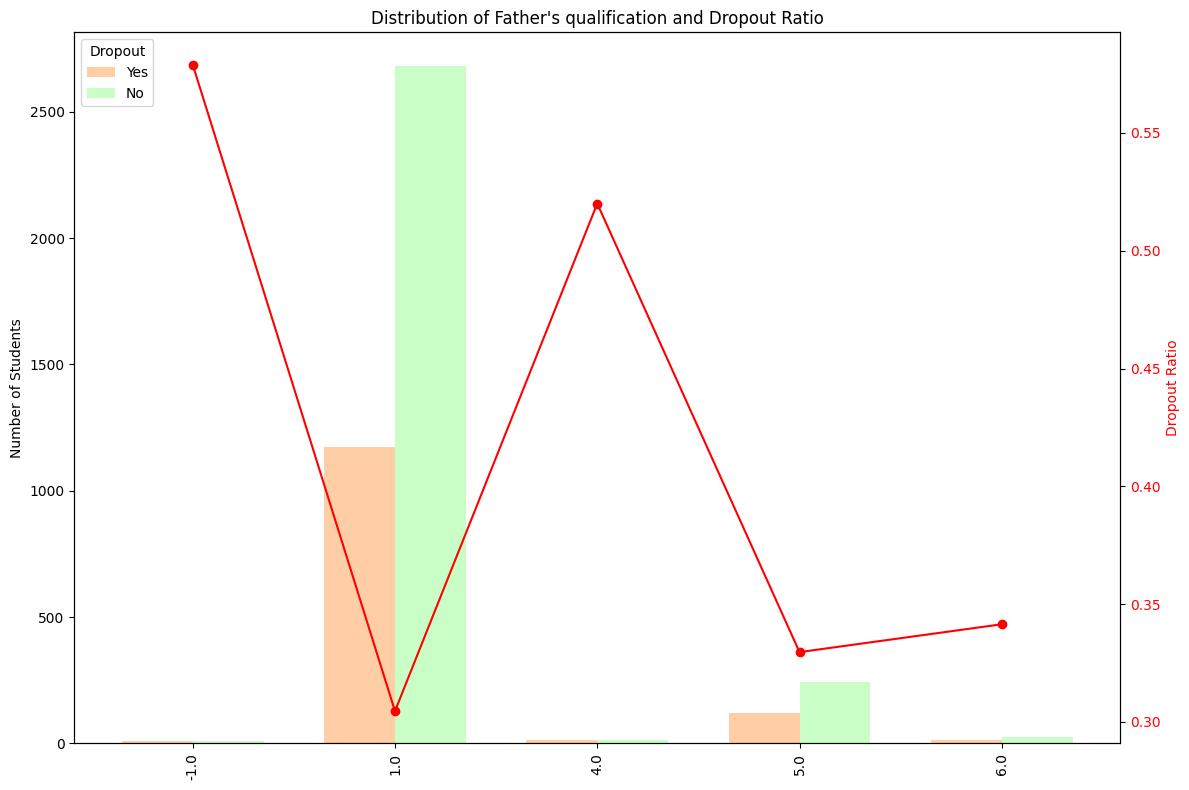

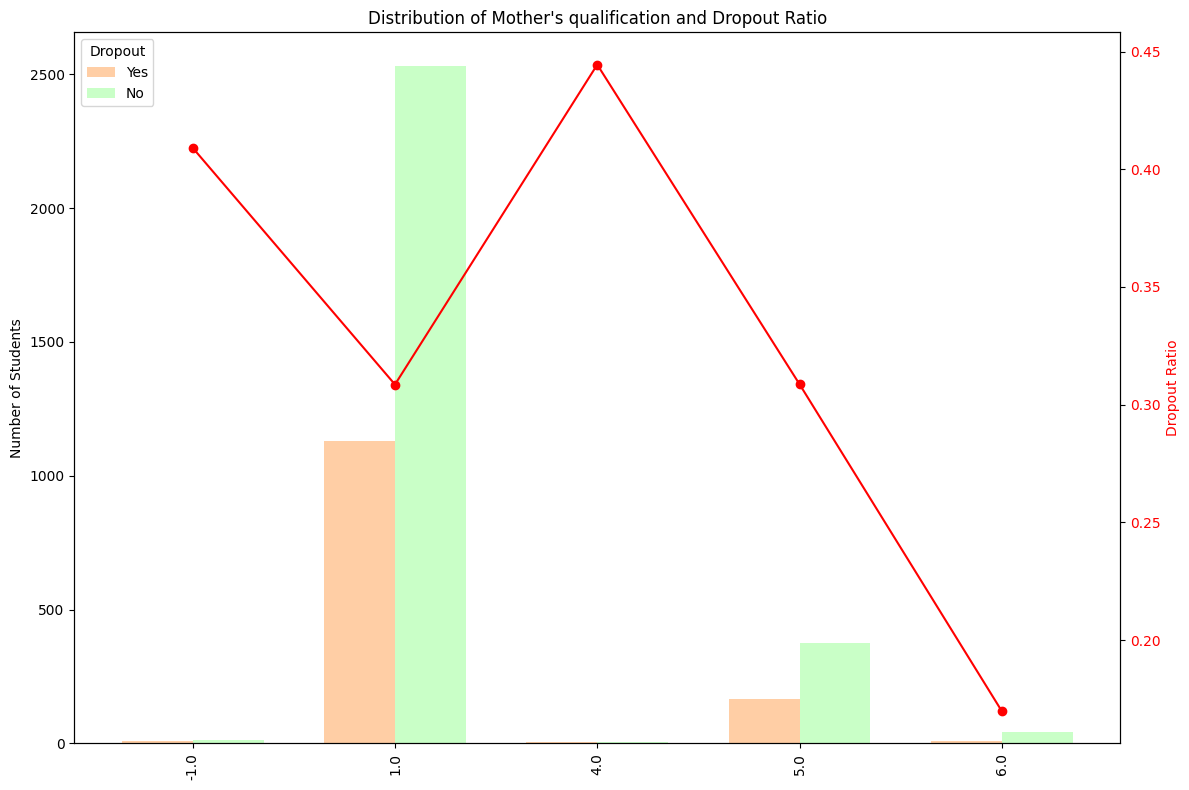

In [206]:
feature_name = "Father's qualification"
plot_feature(feature_name, qualification_groups, features_full)
feature_name = "Mother's qualification"
plot_feature(feature_name, qualification_groups, features_full)

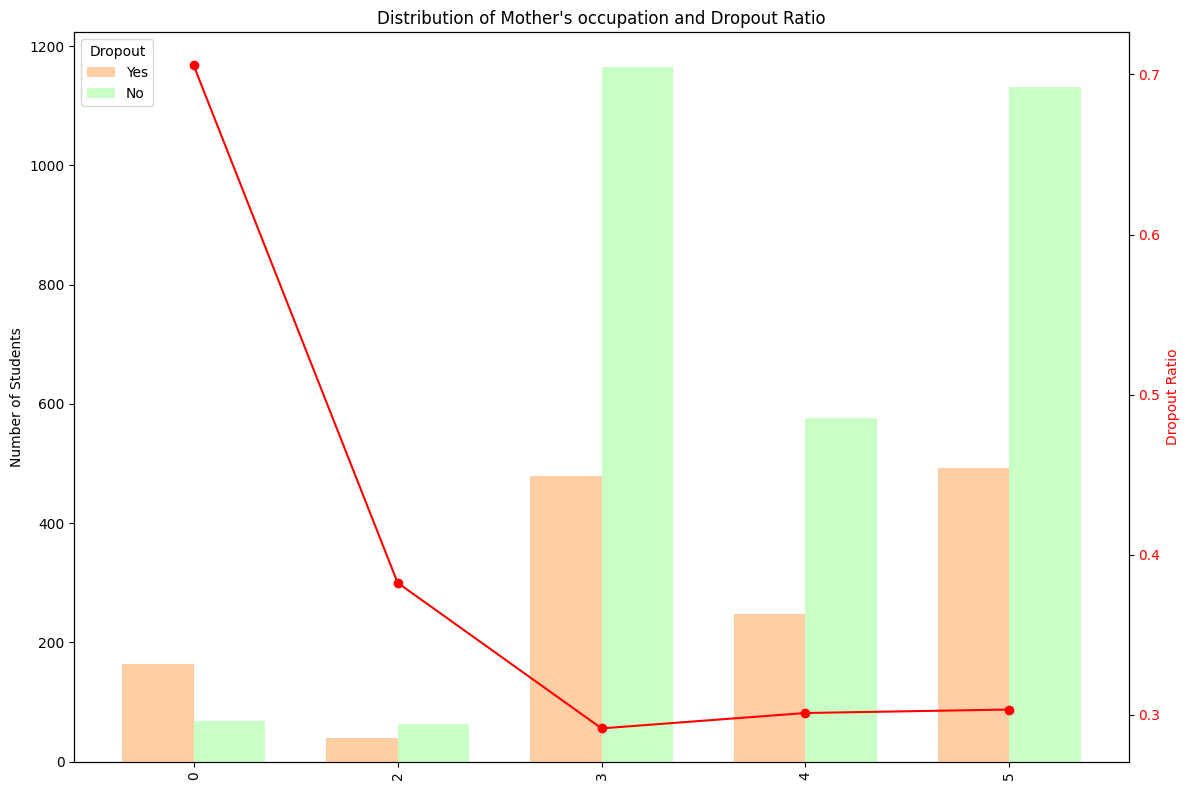

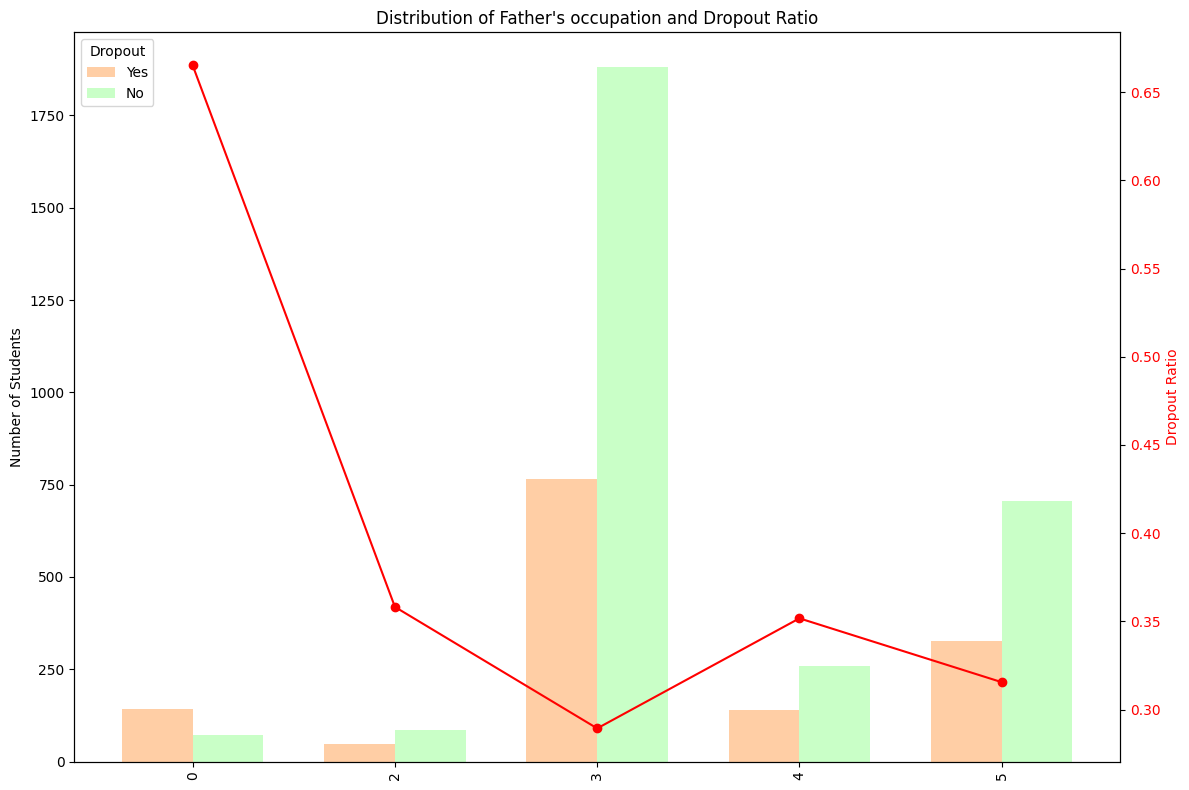

In [207]:
feature_name = "Mother's occupation"
plot_feature(feature_name, occupation_worker_levels, features_full)
feature_name = "Father's occupation"
plot_feature(feature_name, occupation_worker_levels, features_full)

## Correlations

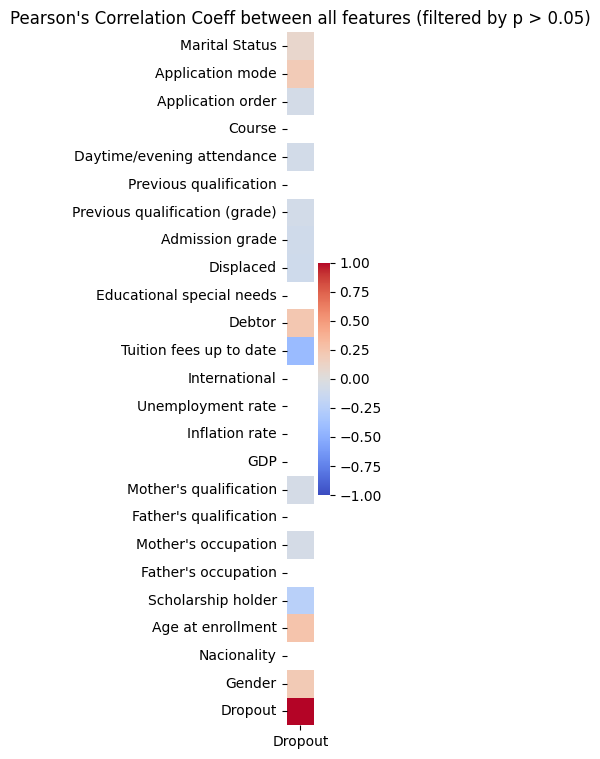

In [208]:
plot_corr(features_full,feature_cols=['Dropout'], show_specific_features=True)

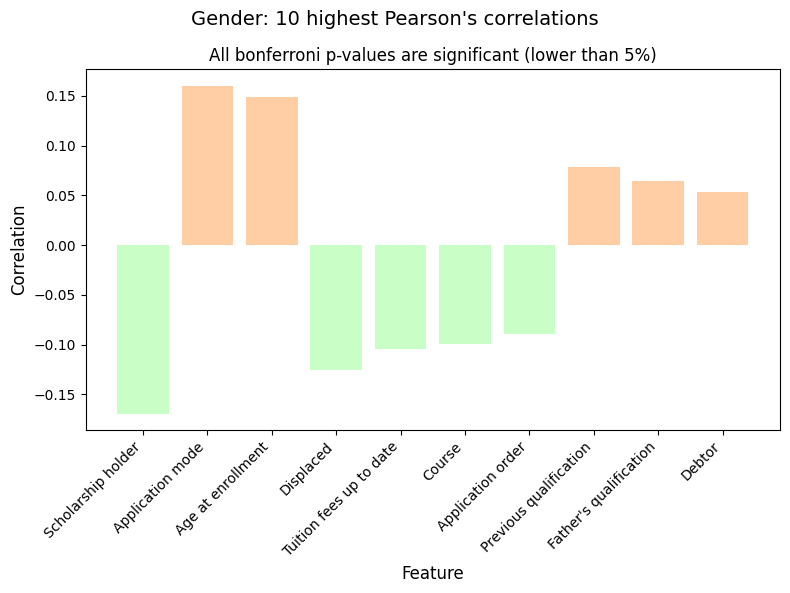

In [209]:
plot_corr(features_full,feature_cols=['Gender'], show_specific_features=True, num_corr=10)

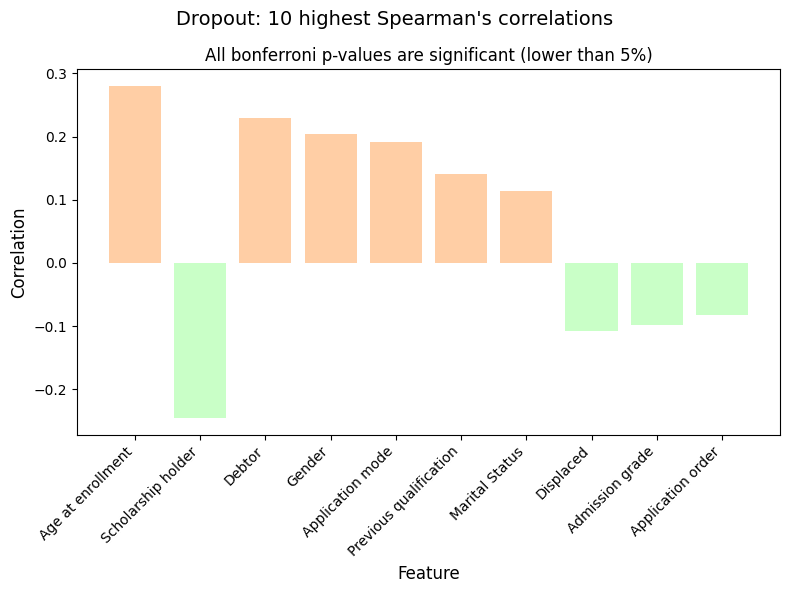

In [210]:
plot_corr(features_full,feature_cols=['Dropout'], show_specific_features=True, method="spearman", num_corr=10)

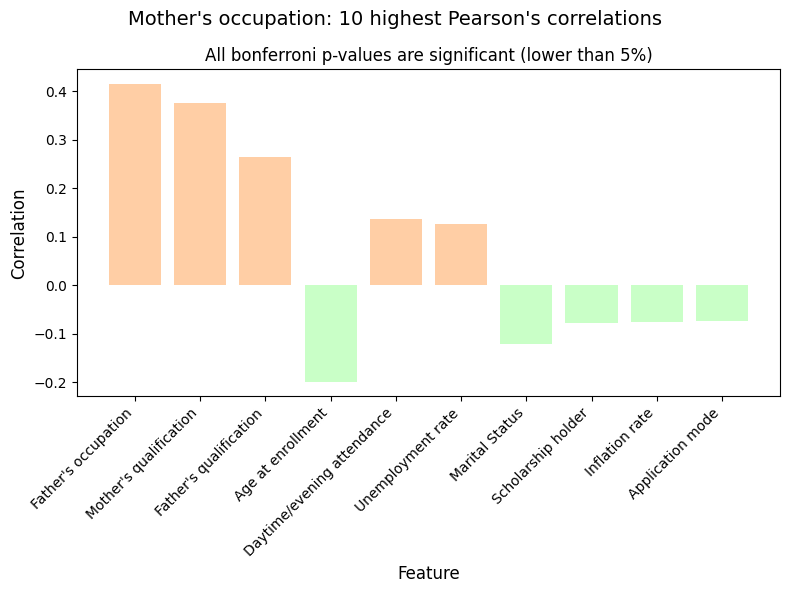

In [211]:
plot_corr(features_full,feature_cols=["Mother's occupation"], show_specific_features=True, num_corr=10)

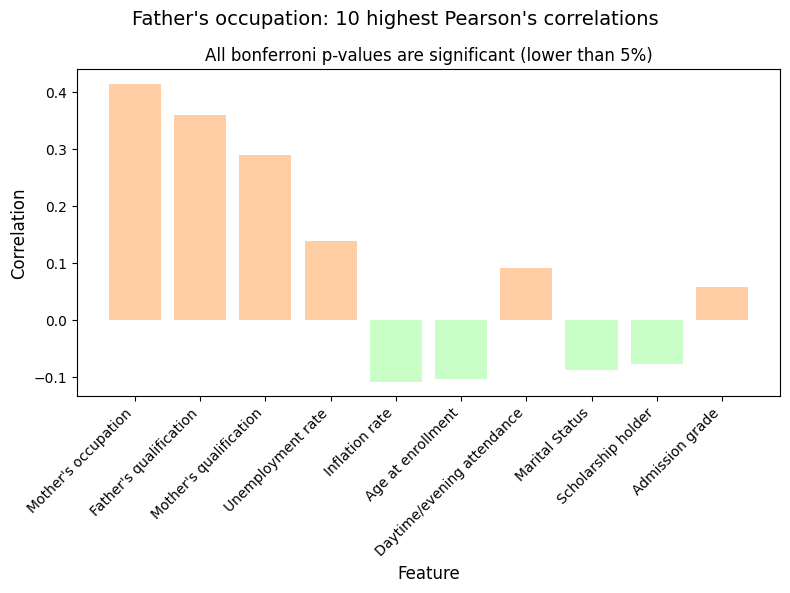

In [212]:
plot_corr(features_full,feature_cols=["Father's occupation"], show_specific_features=True, num_corr=10)

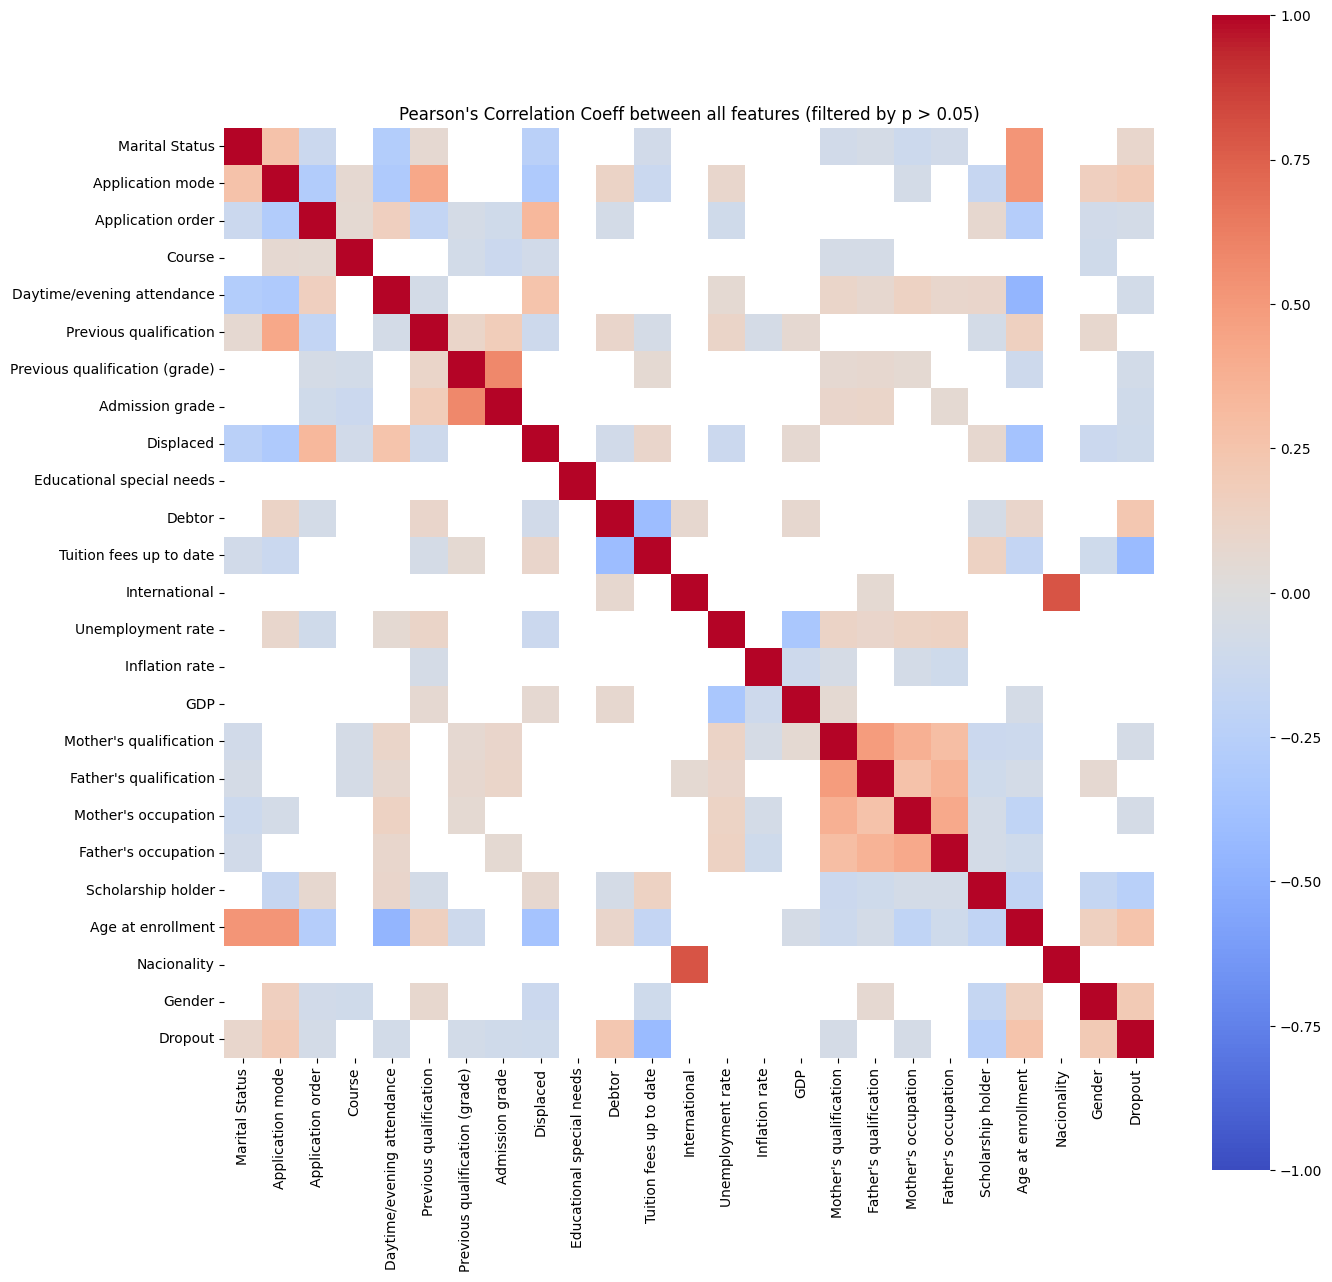

In [213]:
plot_corr(features_full)

# Baseline Model

In [214]:
logreg = LogisticRegression(max_iter=1000, random_state=seed)
RFclf = RandomForestClassifier(max_depth=5,
                                random_state=seed)

## Logistic Regression (White-box Model)

In [215]:
logreg_preds = cross_validator(logreg, features, labels, debias=False)

print("classification report on training data:\n",classification_report(labels, logreg_preds))



gender_log_metric_score = metric_scores(y_test=labels, y_pred = logreg_preds, group_test=groups['Gender'])
gender_log_metric_df = metric_df(gender_log_metric_score, group_names=["Female", "Male"], names=metric_names)


mother_occupation_log_metric_score = metric_scores(y_test=labels, y_pred = logreg_preds, group_test=groups["Mother's occupation"])
mother_occupation_log_metric_df = metric_df(mother_occupation_log_metric_score, group_names=["0", "1","2", "3", "4", "5"], names=metric_names)

father_occupation_log_metric_score = metric_scores(y_test=labels, y_pred = logreg_preds, group_test=groups["Father's occupation"])
father_occupation_log_metric_df = metric_df(father_occupation_log_metric_score, group_names=["0", "1","2", "3", "4", "5"], names=metric_names)


classification report on training data:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85      3003
           1       0.75      0.43      0.55      1421

    accuracy                           0.77      4424
   macro avg       0.76      0.68      0.70      4424
weighted avg       0.77      0.77      0.75      4424



## Random Forest (Black-box Model)

In [216]:
RFclf_preds = cross_validator(RFclf, features, labels, debias=False)

print(classification_report(labels, RFclf_preds))

gender_RF_metric_score = metric_scores(y_test=labels, y_pred=RFclf_preds, group_test=groups['Gender'])
gender_RF_metric_df = metric_df(gender_RF_metric_score, group_names=["Female", "Male"], names=metric_names)

mother_occupation_rf_metric_score = metric_scores(y_test=labels, y_pred = RFclf_preds, group_test=groups["Mother's occupation"])
mother_occupation_rf_metric_df = metric_df(mother_occupation_rf_metric_score, group_names=["0", "1","2", "3", "4", "5"], names=metric_names)

father_occupation_rf_metric_score = metric_scores(y_test=labels, y_pred = RFclf_preds, group_test=groups["Father's occupation"])
father_occupation_rf_metric_df = metric_df(father_occupation_rf_metric_score, group_names=["0", "1","2", "3", "4", "5"], names=metric_names)

              precision    recall  f1-score   support

           0       0.77      0.96      0.86      3003
           1       0.84      0.40      0.54      1421

    accuracy                           0.78      4424
   macro avg       0.81      0.68      0.70      4424
weighted avg       0.79      0.78      0.76      4424



## Compare Logistic Regression and Random Forest Classification

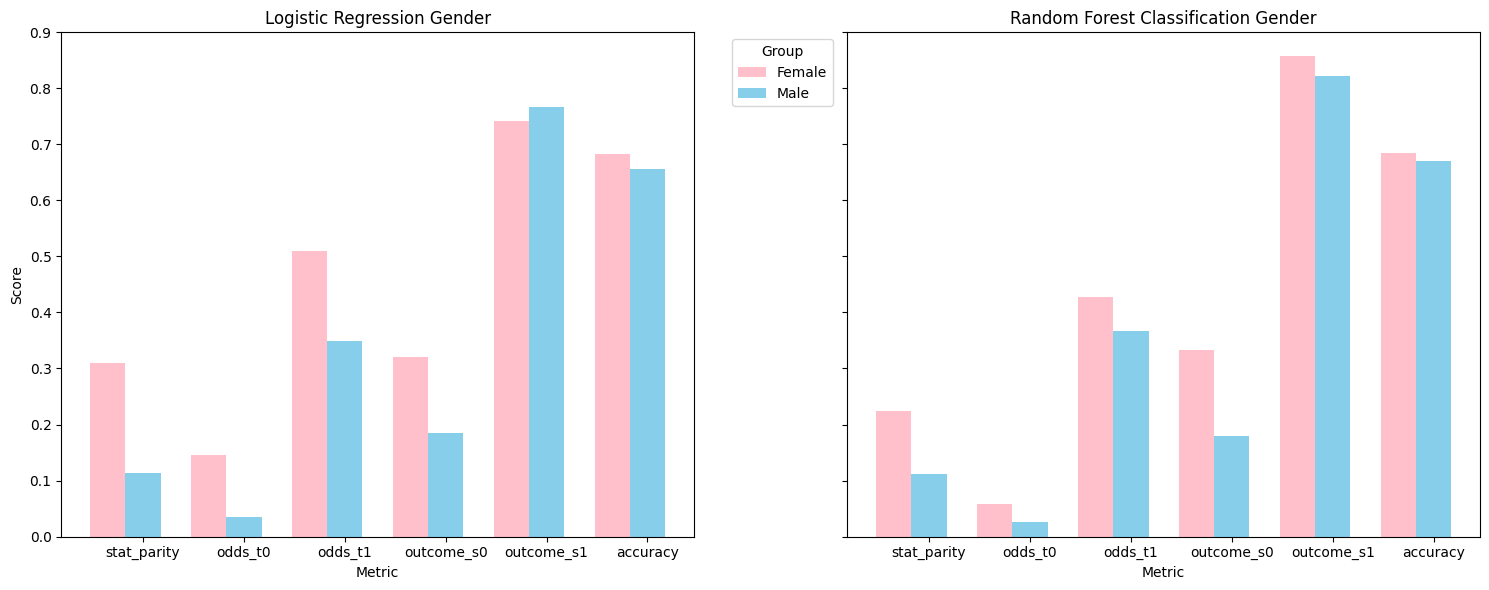

In [217]:
plot_scores_and_group_compare(gender_log_metric_df, gender_RF_metric_df, titles=['Logistic Regression Gender','Random Forest Classification Gender'], color_palette=['pink', 'skyblue'])

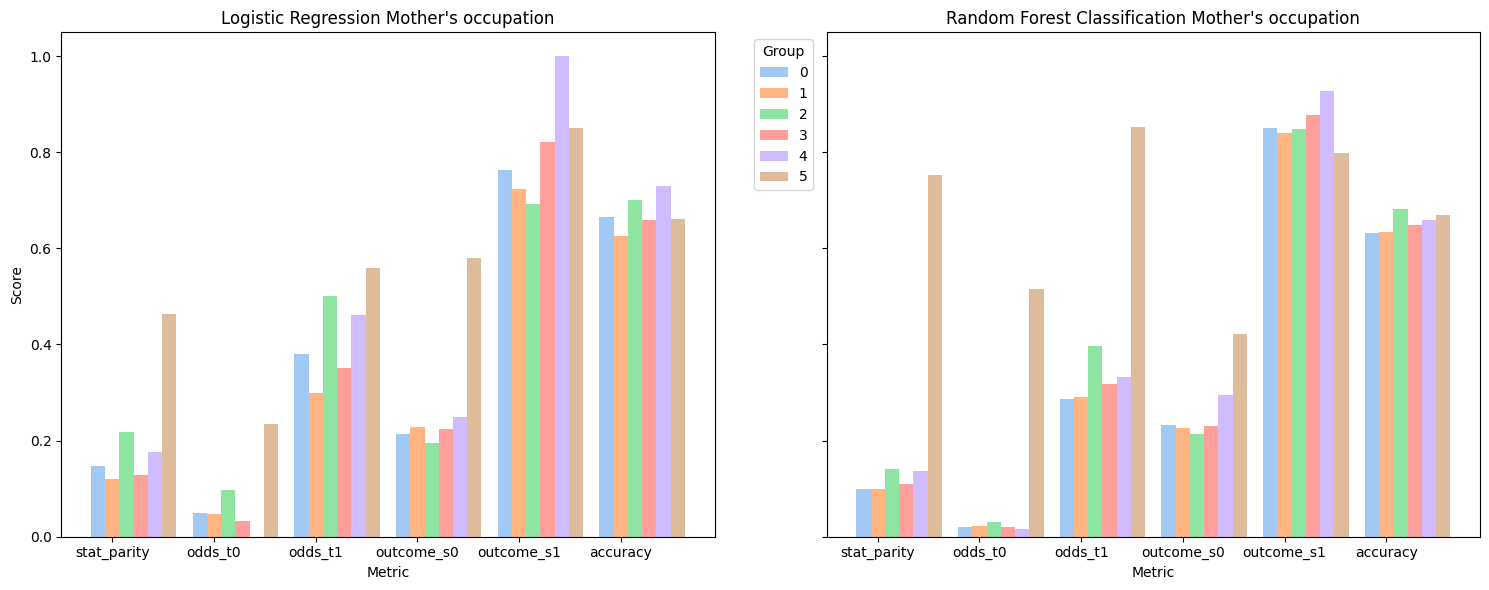

In [218]:
plot_scores_and_group_compare(mother_occupation_log_metric_df, mother_occupation_rf_metric_df, titles=["Logistic Regression Mother's occupation","Random Forest Classification Mother's occupation"], bar_width=0.14)

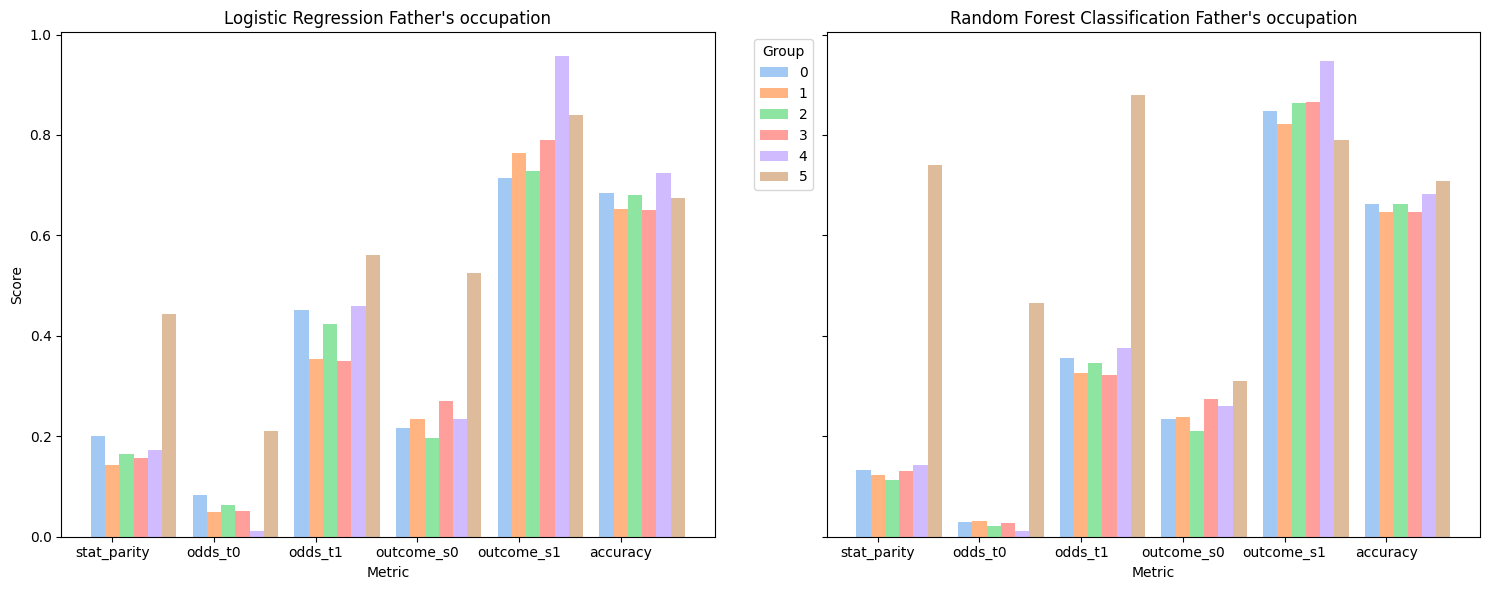

In [219]:
plot_scores_and_group_compare(father_occupation_log_metric_df, father_occupation_rf_metric_df, titles=["Logistic Regression Father's occupation","Random Forest Classification Father's occupation"], bar_width=0.14)

# Debias Data and Model Performance

## Logistic Regression (White-box Model)

In [220]:
logreg_preds = cross_validator(logreg, features, labels, protected_cols, debias=True)

print(classification_report(labels, logreg_preds))
gender_log_metric_score = metric_scores(y_test=labels, y_pred=logreg_preds, group_test=groups['Gender'])
gender_debiased_log_metric_df = metric_df(gender_log_metric_score, group_names=["Female", "Male"], names=metric_names)

mother_occupation_log_metric_score = metric_scores(y_test=labels, y_pred=logreg_preds, group_test=groups["Mother's occupation"])
mother_occupation_debiased_log_metric_df = metric_df(mother_occupation_log_metric_score, group_names=["0", "1", "2", "3", "4", "5"], names=metric_names)

father_occupation_log_metric_score = metric_scores(y_test=labels, y_pred=logreg_preds, group_test=groups["Father's occupation"])
father_occupation_debiased_log_metric_df = metric_df(father_occupation_log_metric_score, group_names=["0", "1", "2", "3", "4", "5"], names=metric_names)

              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3003
           1       0.78      0.37      0.50      1421

    accuracy                           0.76      4424
   macro avg       0.77      0.66      0.67      4424
weighted avg       0.77      0.76      0.73      4424



## Random Forest Classification (Black-box Model)

In [221]:
RFclf_preds = cross_validator(RFclf, features, labels, protected_cols, debias=True)


print(classification_report(labels, RFclf_preds))
RF_metric_score = metric_scores(y_test=labels, y_pred=RFclf_preds, group_test=groups['Gender'])
gender_debiased_RF_metric_df = metric_df(RF_metric_score, group_names=["Female", "Male"], names=metric_names)


mother_occupation_rf_metric_score = metric_scores(y_test=labels, y_pred = RFclf_preds, group_test=groups["Mother's occupation"])
mother_occupation_debiased_rf_metric_df = metric_df(mother_occupation_rf_metric_score, group_names=["0", "1","2", "3", "4", "5"], names=metric_names)

father_occupation_rf_metric_score = metric_scores(y_test=labels, y_pred = RFclf_preds, group_test=groups["Father's occupation"])
father_occupation_debiased_rf_metric_df = metric_df(father_occupation_rf_metric_score, group_names=["0", "1","2", "3", "4", "5"], names=metric_names)

              precision    recall  f1-score   support

           0       0.76      0.97      0.85      3003
           1       0.84      0.36      0.50      1421

    accuracy                           0.77      4424
   macro avg       0.80      0.66      0.68      4424
weighted avg       0.78      0.77      0.74      4424



## Compare Debiased Models

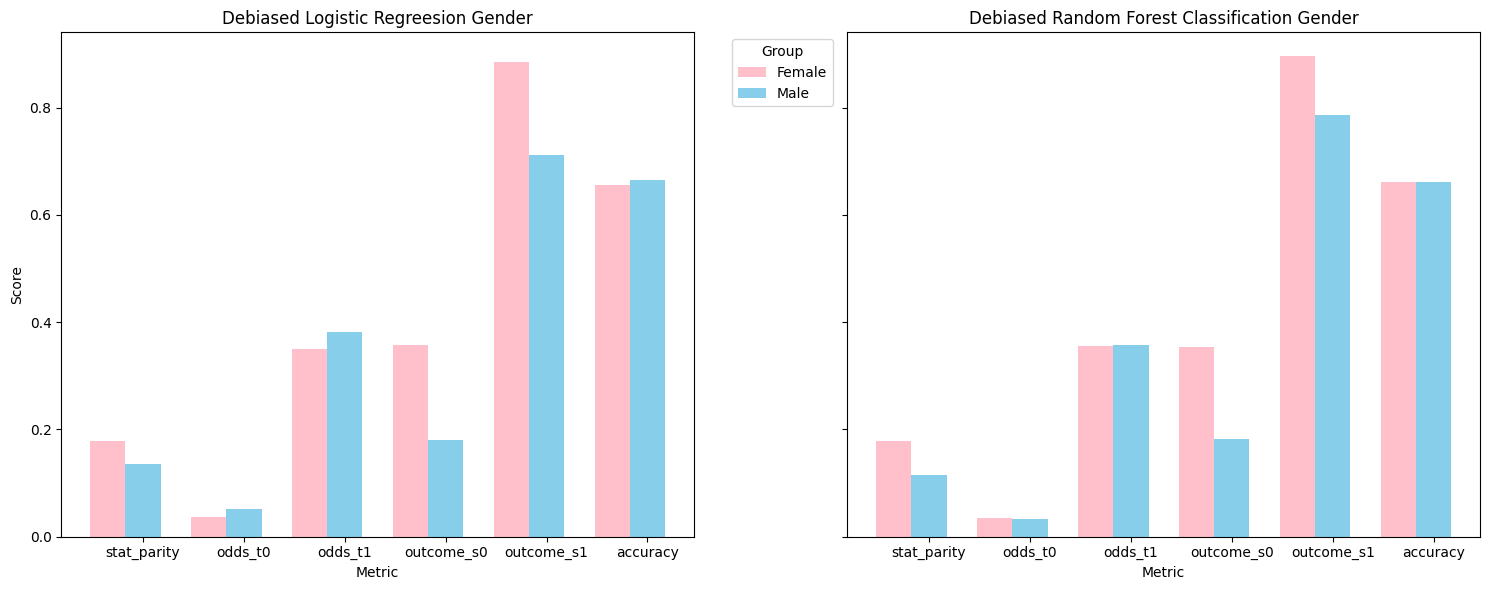

In [222]:
plot_scores_and_group_compare(gender_debiased_log_metric_df, gender_debiased_RF_metric_df, titles=["Debiased Logistic Regreesion Gender", "Debiased Random Forest Classification Gender"], color_palette=['pink', 'skyblue'])

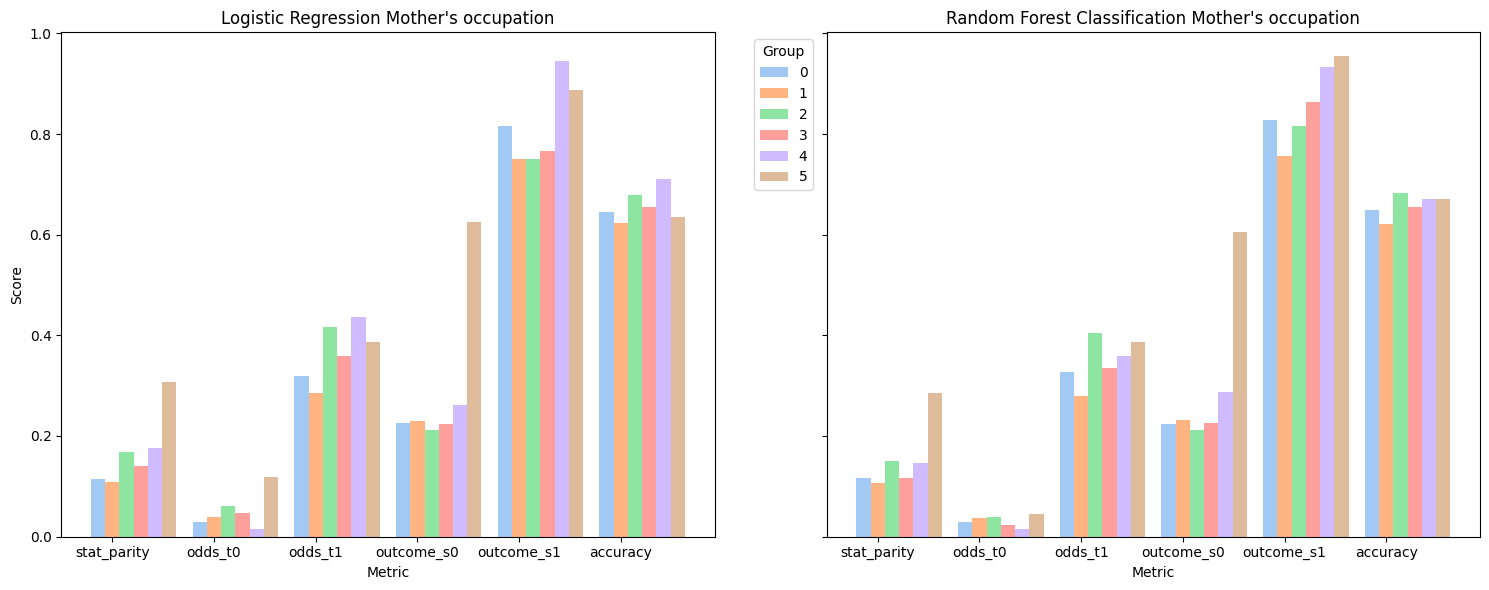

In [223]:
plot_scores_and_group_compare(mother_occupation_debiased_log_metric_df, mother_occupation_debiased_rf_metric_df, titles=["Logistic Regression Mother's occupation","Random Forest Classification Mother's occupation"], bar_width=0.14)

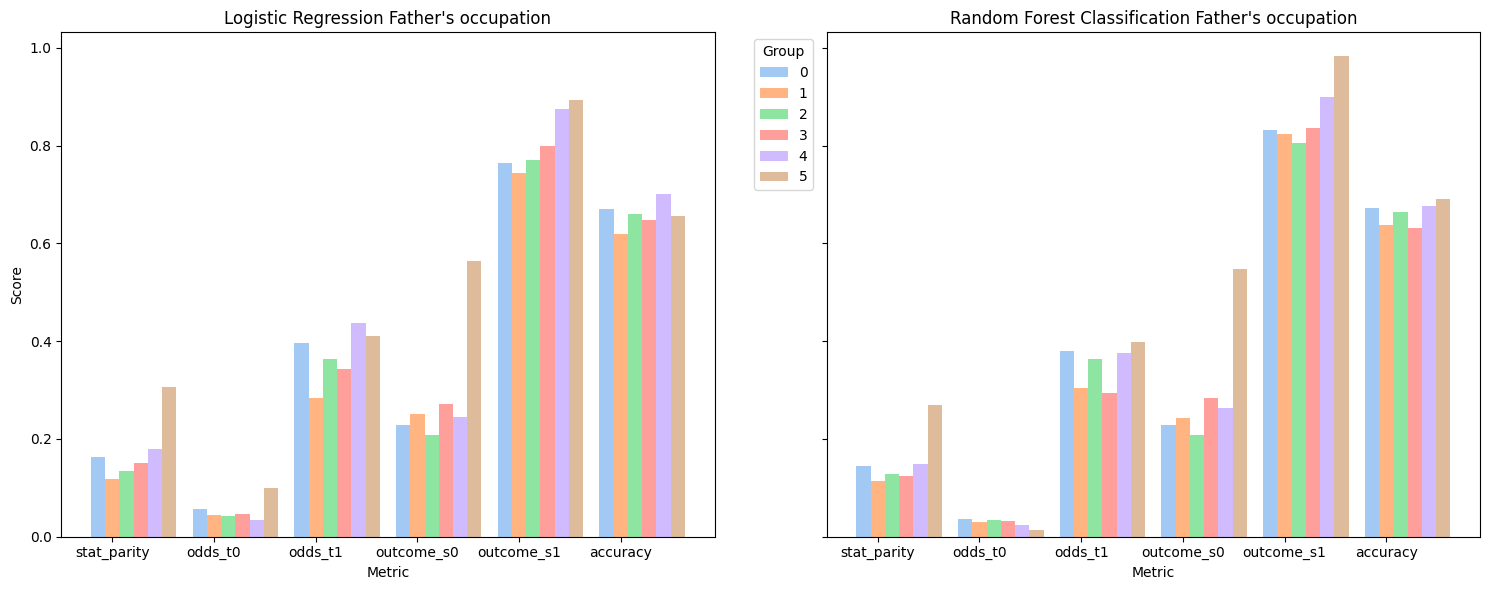

In [224]:
plot_scores_and_group_compare(father_occupation_debiased_log_metric_df, father_occupation_debiased_rf_metric_df, titles=["Logistic Regression Father's occupation","Random Forest Classification Father's occupation"], bar_width=0.14)

## Orginal data vs. Debiased data



### Logistic Regression

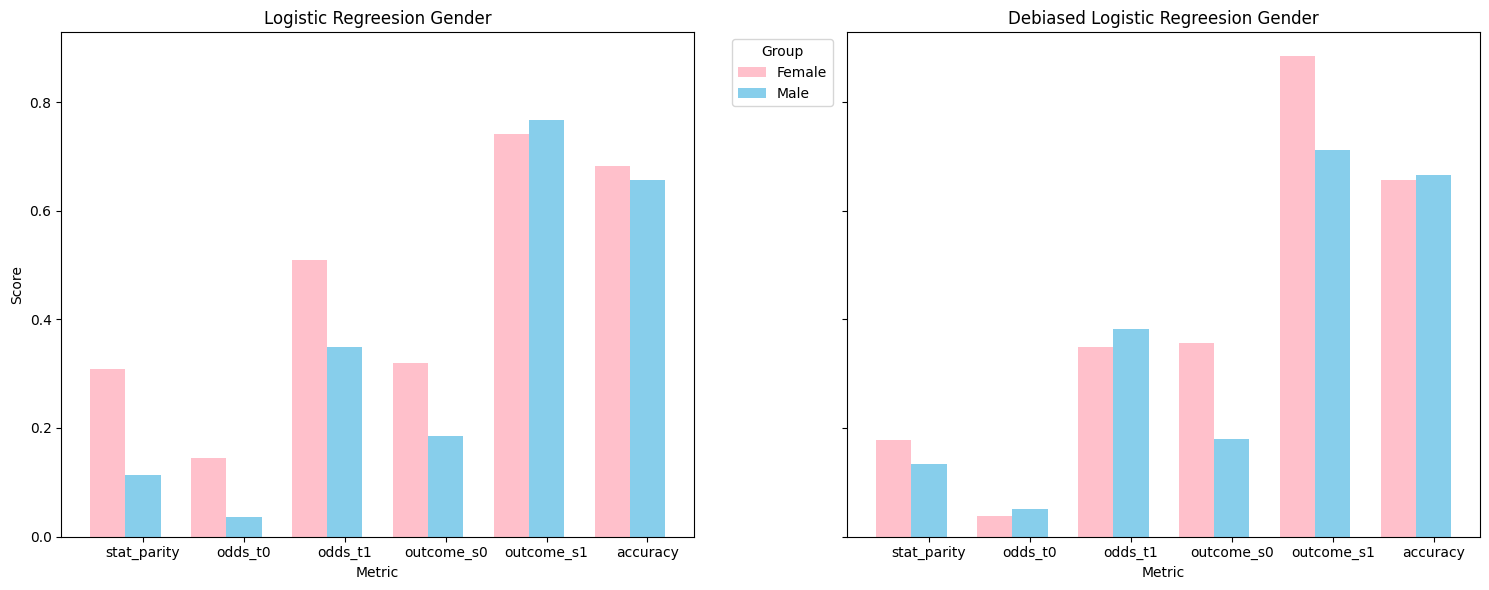

In [225]:
plot_scores_and_group_compare(gender_log_metric_df, gender_debiased_log_metric_df, titles=["Logistic Regreesion Gender", "Debiased Logistic Regreesion Gender"], color_palette=['pink', 'skyblue'])

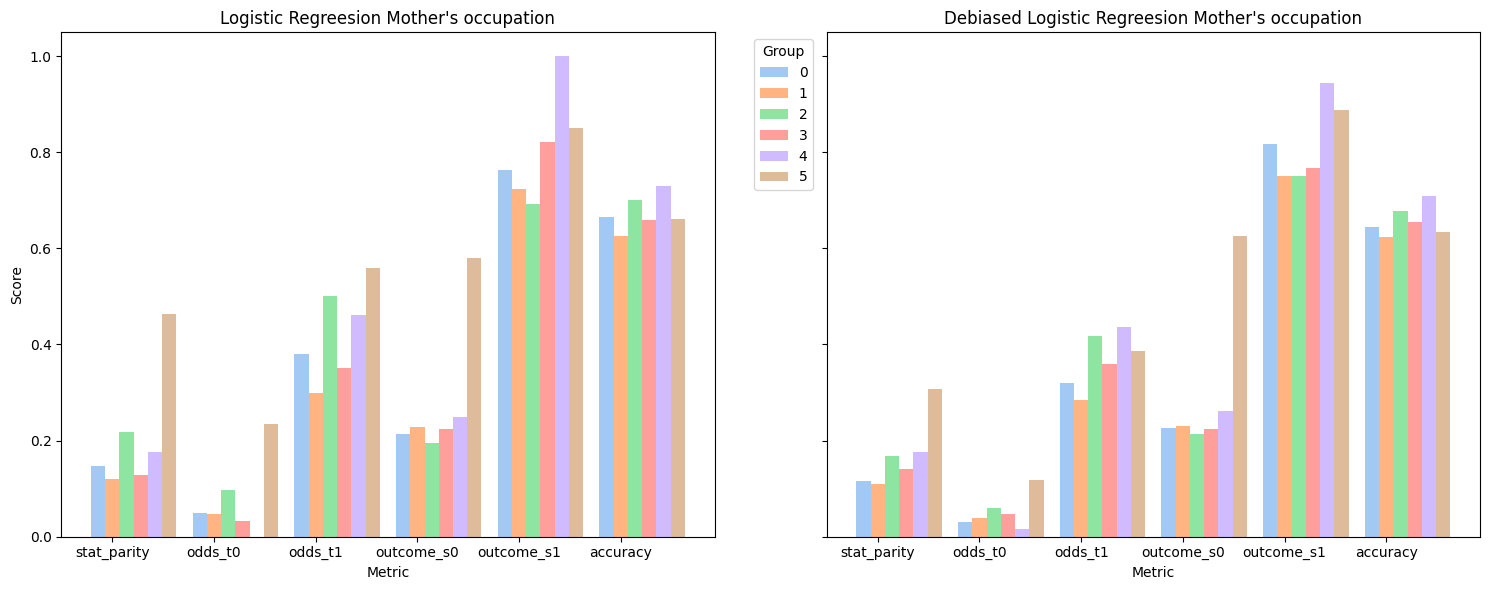

In [226]:
plot_scores_and_group_compare(mother_occupation_log_metric_df, mother_occupation_debiased_log_metric_df, titles=["Logistic Regreesion Mother's occupation", "Debiased Logistic Regreesion Mother's occupation"], bar_width=0.14)

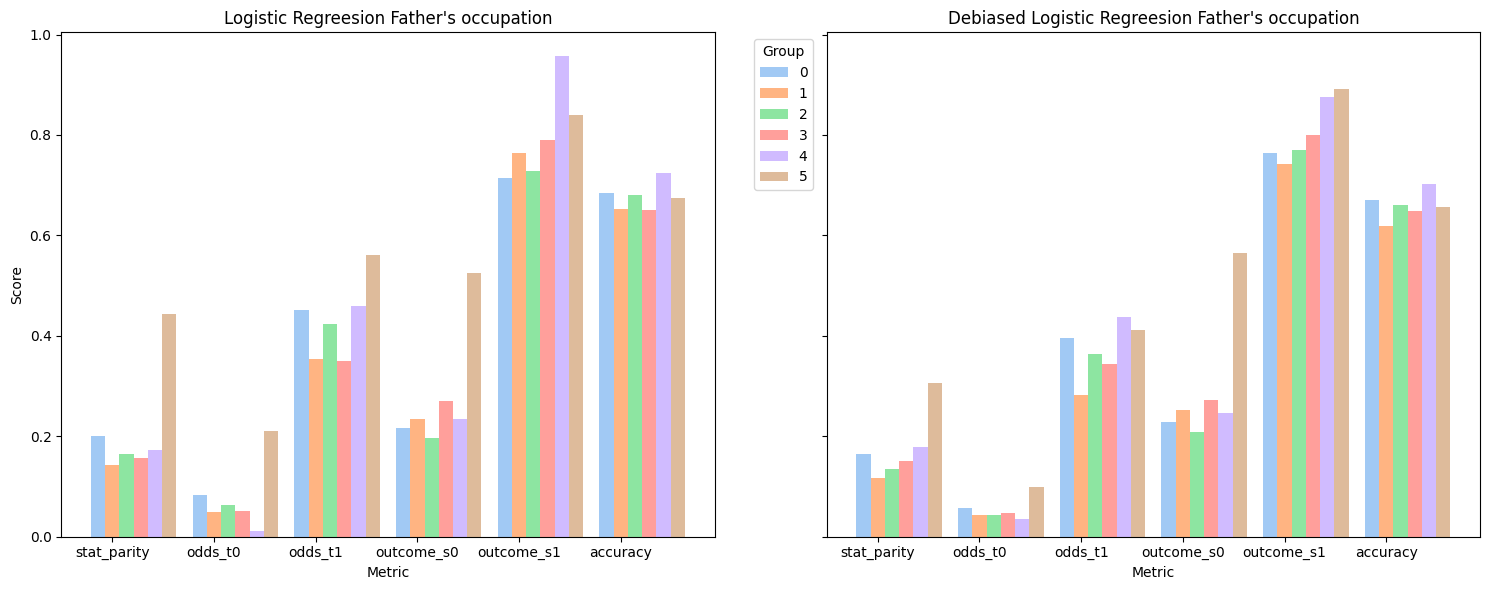

In [227]:
plot_scores_and_group_compare(father_occupation_log_metric_df, father_occupation_debiased_log_metric_df, titles=["Logistic Regreesion Father's occupation", "Debiased Logistic Regreesion Father's occupation"], bar_width=0.14)

### Random Forest Classification

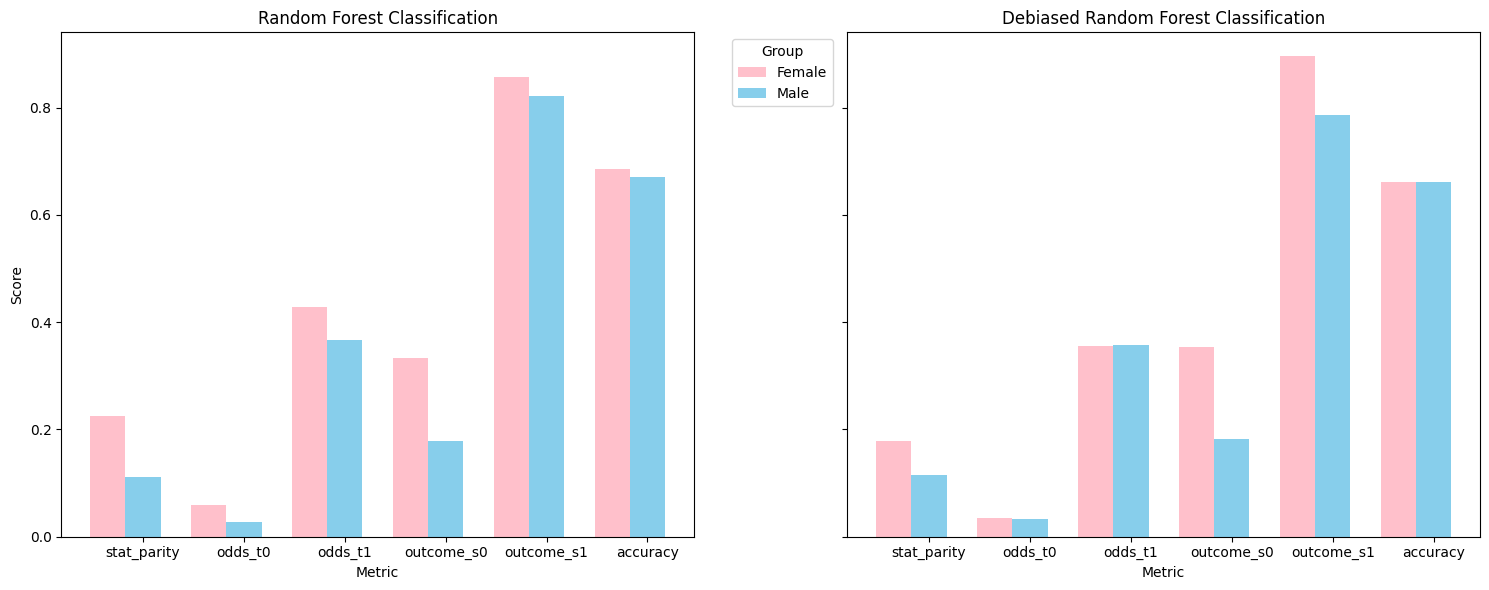

In [228]:
plot_scores_and_group_compare(gender_RF_metric_df, gender_debiased_RF_metric_df, titles=["Random Forest Classification", "Debiased Random Forest Classification"], color_palette=['pink', 'skyblue'])

# Tuning hyper parameters based on accuracy

## Logistic Regression

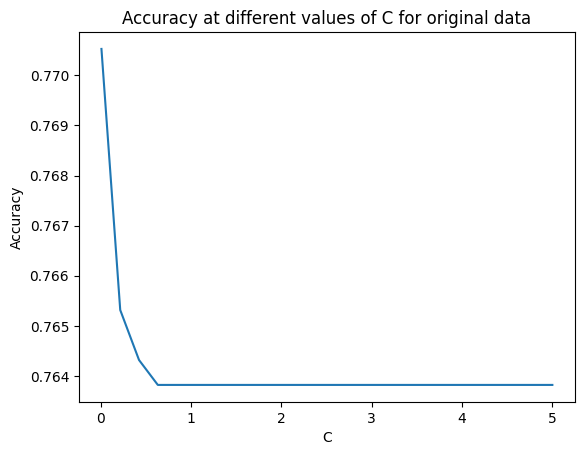

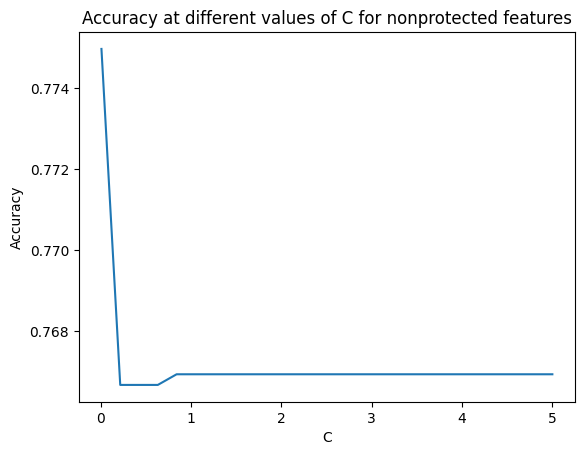

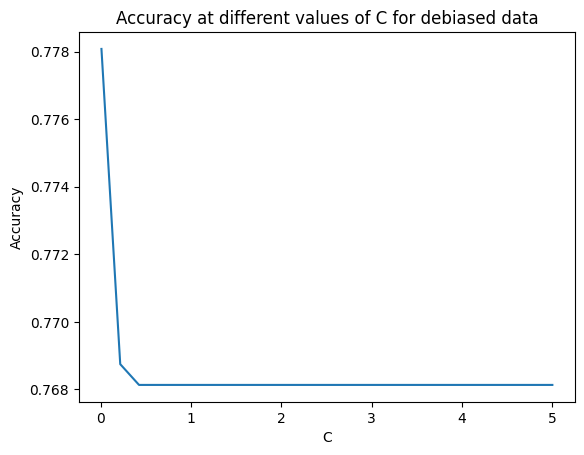

In [229]:
tune_hyper_params(features=features, model = LogisticRegression, param_to_tune='C', fixed_model_params = {'random_state':seed, 'max_iter':1000}, param_values = np.linspace(start=0.01,stop=5,num=25))

## Random Forest Classification

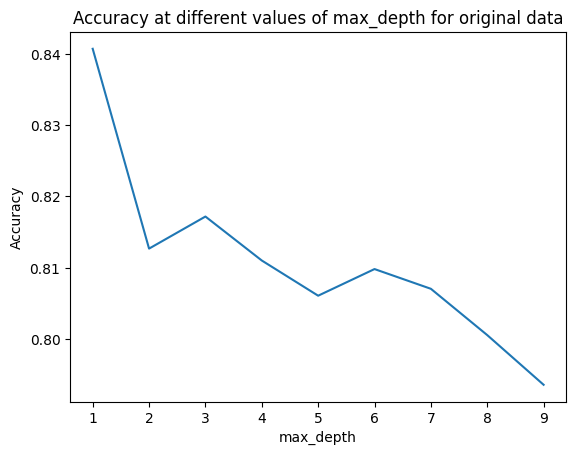

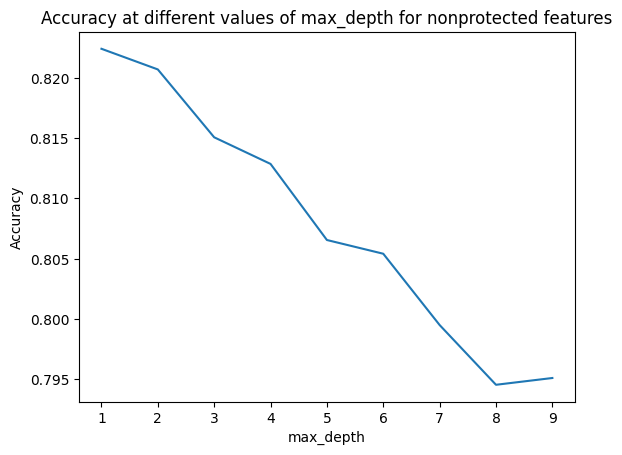

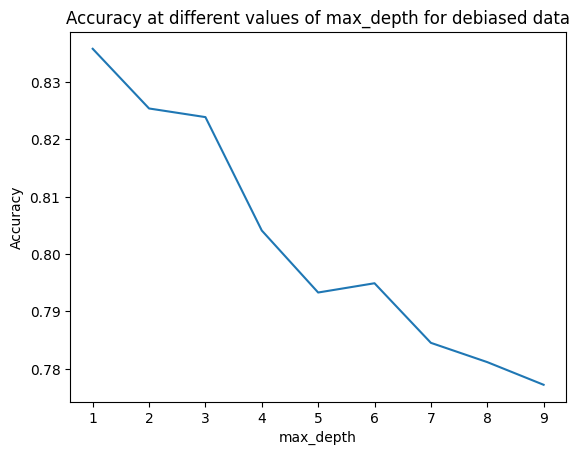

In [230]:
tune_hyper_params(features=features, model = RandomForestClassifier, param_to_tune='max_depth', fixed_model_params = {'random_state':seed}, param_values = [i for i in range(1, 10)])

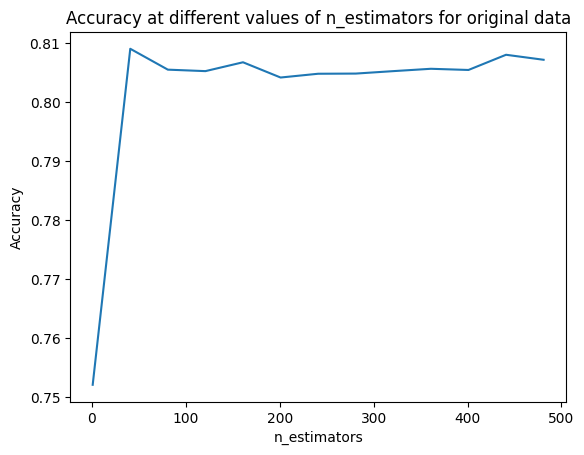

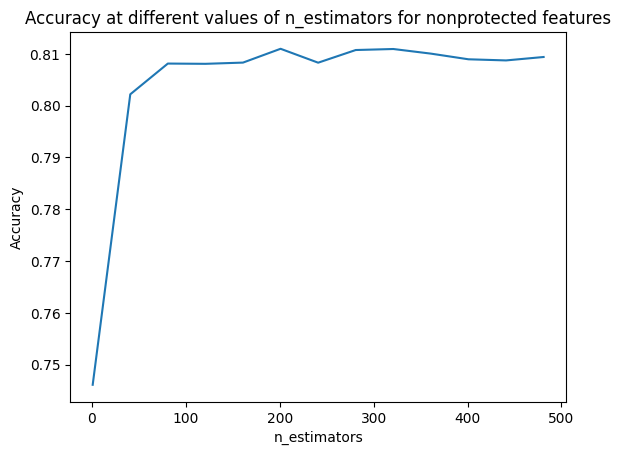

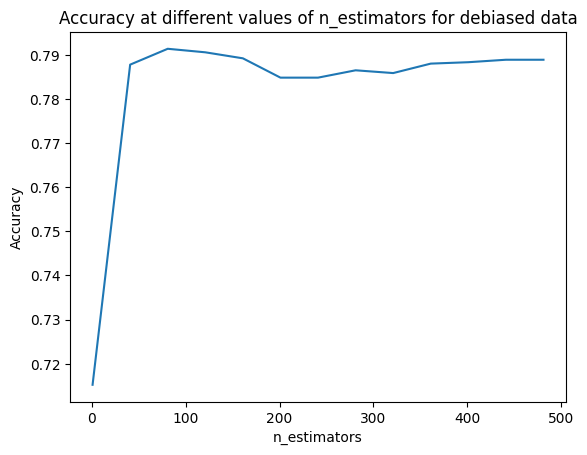

In [231]:
tune_hyper_params(features=features, model = RandomForestClassifier, param_to_tune='n_estimators', fixed_model_params = {'random_state':seed, 'max_depth':6}, param_values = [i for i in range(1, 500, 40)])

# Model Explainability

In [232]:
weights_orgin_data, weights_np, weights_debiased = feature_weights(features=features, model=LogisticRegression(max_iter=1000, random_state=seed, C=0.05), top_n=10)

In [233]:
weights_orgin_data

,coef,odds
Tuition fees up to date,-1.396,0.247
Scholarship holder,-0.920,0.398
Gender,0.791,2.206
Debtor,0.701,2.015
Marital Status,-0.213,0.808
Daytime/evening attendance,0.165,1.179
Mother's qualification,-0.149,0.861
Application order,0.083,1.087
Father's occupation,-0.079,0.924
Father's qualification,0.074,1.076


In [234]:
weights_np

,coef,odds
Tuition fees up to date,-0.822,0.440
Scholarship holder,-0.527,0.590
Age at enrollment,0.356,1.427
International,-0.224,0.800
Application mode,0.187,1.206
Admission grade,-0.184,0.832
Debtor,0.170,1.185
Nacionality,0.154,1.167
Mother's qualification,-0.115,0.891
Course,-0.108,0.897


In [235]:
weights_debiased

,coef,odds
Tuition fees up to date,-0.764,0.466
Scholarship holder,-0.455,0.634
Age at enrollment,0.312,1.366
International,-0.200,0.819
Admission grade,-0.186,0.831
Debtor,0.163,1.177
Application mode,0.158,1.171
Nacionality,0.147,1.158
Mother's qualification,-0.102,0.903
Course,-0.076,0.927


# Try things out...

In [236]:
def tune_lambda(model, X, y, protected_cols):

  def calculate_true_positives(y_preds):
    tn, fp, fn, tp = confusion_matrix(y, y_preds).ravel()
    true_positives = tp / (tp + fn)
    return true_positives


  lambda_values = np.linspace(0, 1, 2)  # 11 values from 0 to 1

  col_names = [f"{g} {v}" for g in protected_cols for v in groups[g].unique()] #[v for g in protected_cols for for v in groups[g].unique()]

  accuracies = pd.DataFrame(columns=col_names)
  print(accuracies.index)
  print(accuracies)
  f1_scores = pd.DataFrame(columns=col_names)
  positive_rates = pd.DataFrame(columns=col_names)

  y_preds = []

  for l in lambda_values:

      y_preds = cross_validator(model, X, y, protected_cols=protected_cols, debias=True, lambd=l)

      acs = []
      fs = []
      pos = []
      all_true_positive = calculate_true_positives(y_preds)


      for g in protected_cols:
        for j in range(groups[g].nunique()): # I don't think the order of j is correct.. but I don't know if it matters
          acs.append(balanced_accuracy_score(y[groups[g]==j], y_preds[groups[g]==j]))
          fs.append(f1_score(y[groups[g]==j], y_preds[groups[g]==j]))
          #pos.append(all_true_positive[groups[g]==j])
      print("acs:", pd.DataFrame(acs))
      accuracies = pd.concat([accuracies, pd.DataFrame(acs, columns=col_names).T])
      print(accuracies)


      #fs = f1_score(y, y_preds)

      #print(pd.DataFrame(acs))
      #pd.concat([accuracies, pd.DataFrame(acs).T])
      #print("here 2")
      #f1_scores = pd.concat([f1_scores, pd.DataFrame(fs)])
      positive_rates = pd.concat([positive_rates, pd.DataFrame(pos)])


      print(f'Lambda {l:.1f} completed')


  print( "acc",accuracies.index)
  print("lvalues", lambda_values)
  accuracies.index = lambda_values
  f1_scores.index = lambda_values
  positive_rates.index = lambda_values

In [237]:
tune_lambda(model=LogisticRegression(max_iter=1000, random_state=seed), X=features, y=labels, protected_cols=['Gender'])

RangeIndex(start=0, stop=0, step=1)
Empty DataFrame
Columns: [Gender 1, Gender 0]
Index: []
acs:           0
0  0.675081
1  0.657007


ValueError: Shape of passed values is (2, 1), indices imply (2, 2)

In [ ]:
        for i in [0,1]:
            for j in [0,1]:
                acc.append(balanced_accuracy_score(y_test[X_p_test.iloc[:,i]==j], y_hat[X_p_test.iloc[:,i]==j]))
                f1s.append(f1_score(y_test[X_p_test.iloc[:,i]==j], y_hat[X_p_test.iloc[:,i]==j]))
                pr.append(np.mean(y_hat[X_p_test.iloc[:,i]==j]))
        accuracies.append(acc)
        f1.append(f1s)
        pos_rates.append(pr)


        protected_idx = [X_train.columns.get_loc(col) for col in protected_cols]


In [ ]:
groups